# Generic functions

In [55]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [56]:
f = open("traffic.txt","r").readlines()

In [63]:
d = pd.read_csv('traffic.txt',sep=',',dtype=np.float32, header=None)[2]
# d.columns = ['Australia','British','Canada','Switzerland','China','Japan','New Zealand','Singapore']

In [64]:
d

0        0.0289
1        0.0350
2        0.0267
3        0.0218
4        0.0191
5        0.0213
6        0.0259
7        0.0249
8        0.0288
9        0.0359
10       0.0465
11       0.0535
12       0.0605
13       0.0654
14       0.0681
15       0.0686
16       0.0889
17       0.1354
18       0.0529
19       0.0445
20       0.0403
21       0.0357
22       0.0282
23       0.0183
24       0.0124
25       0.0112
26       0.0120
27       0.0123
28       0.0215
29       0.0411
          ...  
17514    0.2198
17515    0.1674
17516    0.0537
17517    0.0507
17518    0.0460
17519    0.0312
17520    0.0215
17521    0.0166
17522    0.0145
17523    0.0148
17524    0.0187
17525    0.0278
17526    0.0418
17527    0.0490
17528    0.0699
17529    0.0989
17530    0.1012
17531    0.1516
17532    0.1811
17533    0.1644
17534    0.1332
17535    0.1587
17536    0.2350
17537    0.2608
17538    0.2405
17539    0.1378
17540    0.0542
17541    0.0551
17542    0.0496
17543    0.0365
Name: 2, Length: 17544, 

In [3]:
import warnings
warnings.filterwarnings("ignore")

import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle as pkl
from scipy.signal import butter, savgol_filter
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
import keras.layers as L
import tensorflow as tf
from sklearn import linear_model
from keras import callbacks
import keras.models as M
import keras.backend as K
import keras.optimizers as O
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

%matplotlib inline
# tf.set_random_seed(103)

Using TensorFlow backend.


In [3]:
# Custom metric function to compute the RMSE.
def rmse(ytrue,ypred):
    tf.reshape(ytrue,[-1,1])
    tf.reshape(ypred,[-1,1])
    return K.sqrt(K.mean(K.square(ytrue - ypred),axis=-1))

In [4]:
def create_time_stepped_data(df, time_steps,num_features):
    d = []
    for i in range(time_steps):
        d.append(df.shift(-i).values[:-time_steps].reshape(-1,num_features+1))
    return np.transpose(np.array(d),(1,0,2))

In [5]:
def create_formatted_data(df, time_steps, num_features, fut_type=1):
    assert (time_steps%2 !=0), "Time steps should be odd!"
    d = create_time_stepped_data(df, time_steps, num_features)
    
    past = d[:,:int(time_steps/2),:]
    if(fut_type == 1):
        fut = np.flip(d[:,int(time_steps/2)+1:,:],1)
    else:
        fut = np.flip(d[:,:int(time_steps/2),:],1)
    y = d[:,int(time_steps/2),-1]
#     if(num_features == 0):
#         cur = np.zeros((d.shape[0],1,256))
#     else:
#         cur = d[:,int(time_steps/2),:-1]
#         cur = np.dstack((cur.reshape(-1,1,num_features),np.zeros(shape=(d.shape[0],1,256-num_features))))
#     for i in range(past.shape[0]):
#         for j in range(past.shape[1]):
#             past[i][j] = (past[i][j] - df.mean())/df.var()
#             fut[i][j] = (fut[i][j] - df.mean())/df.var()
    return past,fut,y

In [6]:
def train_test_split(past,fut,y,df):
    train_split = int(0.8*y.shape[0])
    
    #'df' is a pd series.
#     mx = df.iloc[:train_split].max()
#     mn = df.iloc[:train_split].min()
    
#     return (past[:train_split]-mn)/(mx-mn), (past[train_split:]-mn)/(mx-mn), (fut[:train_split]-mn)/(mx-mn), np.zeros_like(past[train_split:]), y[:train_split], y[train_split:]
    return past[:train_split], past[train_split:], fut[:train_split], np.zeros_like(past[train_split:]), y[:train_split], y[train_split:]

In [7]:
def distributed_lstm_model(input_shape1, input_shape2, loss = 1):
    
    past_inp = L.Input(shape=(input_shape1))
    fut_inp = L.Input(shape=(input_shape2))
    
#     cnn1 = L.Conv1D(filters=16,kernel_size=5)(past_inp)
#     cnn1 = L.Conv1D(filters=8,kernel_size=2)(cnn1)
#     cnn1 = L.Dense(32)(cnn1)
#     cnn1 = L.advanced_activations.LeakyReLU(0.2)(cnn1)
        
    lstm_out1 = L.LSTM(8, recurrent_dropout=0.3, return_sequences=True, bias_initializer='ones')(past_inp)
#     x1 = L.LSTM(16, recurrent_dropout=0.3, return_sequences=True, bias_initializer='ones')(x1)
#     lstm_out1 = L.LSTM(32, recurrent_dropout=0.3, return_sequences=True, bias_initializer='ones')(x1)
    
#     lstm_out1 = L.Average()([cnn1,lstm_out1])
#     lstm_out1 = L.Concatenate(axis=1)([cnn1,lstm_out1])
    
#     cnn2 = L.Conv1D(filters=16,kernel_size=5)(fut_inp)
#     cnn2 = L.Conv1D(filters=8,kernel_size=2)(cnn2)
#     cnn2 = L.Dense(32)(cnn2)
#     cnn2 = L.advanced_activations.LeakyReLU(0.2)(cnn2)
        
    lstm_out2 = L.LSTM(8, recurrent_dropout=0.3, return_sequences=True, bias_initializer='ones')(fut_inp)
#     x2 = L.LSTM(16, recurrent_dropout=0.3, return_sequences=True, bias_initializer='ones')(x2)
#     lstm_out2 = L.LSTM(32, recurrent_dropout=0.3, return_sequences=True, bias_initializer='ones')(x2)
    
#     lstm_out2 = L.Average()([cnn2,lstm_out2])
#     lstm_out2 = L.Concatenate(axis=1)([cnn2,lstm_out2])
    
#     x = L.Average()([cnn1,cnn2])
    x = L.Average()([lstm_out1,lstm_out2])
    x = L.Flatten()(x)
    
#     x = L.Dense(32)(x)
#     x = L.advanced_activations.LeakyReLU(0.2)(x)
#     x = L.Dense(32)(x)
#     x = L.advanced_activations.LeakyReLU(0.2)(x)
#     x = L.Dense(32)(x)
#     x = L.advanced_activations.LeakyReLU(0.2)(x)
    x = L.Dense(32)(x)
    x = L.advanced_activations.LeakyReLU(0.2)(x)
    x = L.Dense(32)(x)
    x = L.advanced_activations.LeakyReLU(0.2)(x)
    x = L.Dense(32)(x)
    x = L.advanced_activations.LeakyReLU(0.2)(x)
    x = L.Dense(1)(x)
    
    main_out = L.advanced_activations.LeakyReLU(0.2)(x)
    
    model = M.Model(inputs=[past_inp, fut_inp], outputs=[main_out], name='M2V1') 
    model.summary()
    optimizer = O.Adam(lr=0.01,decay=0.9)
    if(loss == 1):
        model.compile(optimizer=optimizer,loss=tf.losses.huber_loss,metrics=['mae',rmse])
    else:
        model.compile(optimizer='adam',loss='mse',metrics=['mae'])
    
    return model    

In [8]:
def common_lstm_model(input_shape1, input_shape2, loss=1,op_sequence = False,num_nodes=24):
    """
    op_sequence : False, by default. If True, then also uses the num_nodes parameter.
    num_nodes   : The number that denotes that how many values to predict at the output layer.
    """
    past_inp = L.Input(shape=(input_shape1))
    fut_inp = L.Input(shape=(input_shape2))
    
    cnn1 = L.Conv1D(filters=16,kernel_size=5)(past_inp)
    cnn1 = L.Conv1D(filters=8,kernel_size=3)(cnn1)
    cnn1 = L.Dense(32)(cnn1)
    cnn1 = L.advanced_activations.LeakyReLU(0.2)(cnn1)
    
    cnn2 = L.Conv1D(filters=16,kernel_size=5)(fut_inp)
    cnn2 = L.Conv1D(filters=8,kernel_size=3)(cnn2)
    cnn2 = L.Dense(32)(cnn2)
    cnn2 = L.advanced_activations.LeakyReLU(0.2)(cnn2)
    
    lstm_inp = L.Average()([cnn1,cnn2])
#     lstm_inp = L.Concatenate(axis=1)([cnn1,cnn2])
    
    lstm_out = L.LSTM(32, recurrent_dropout=0.2, return_sequences=True, bias_initializer='ones')(lstm_inp)
#     x1 = L.LSTM(16,  recurrent_dropout=0.2, return_sequences=True, bias_initializer='he_normal')(x1)
#     lstm_out = L.LSTM(32, recurrent_dropout=0.2, return_sequences=True, bias_initializer='he_normal')(x1)
    
#     x1 = L.Concatenate(axis=1)([lstm_out,lstm_inp])
    x1 = L.Average()([lstm_out,lstm_inp])
    x1 = L.Flatten()(x1)
    
    x1 = L.Dense(256)(x1)
    x1 = L.advanced_activations.LeakyReLU(0.2)(x1)
    x1 = L.Dense(256)(x1)
    x1 = L.advanced_activations.LeakyReLU(0.2)(x1)
    x1 = L.Dense(256)(x1)
    x1 = L.advanced_activations.LeakyReLU(0.2)(x1)
    x1 = L.Dense(256)(x1)
    x1 = L.advanced_activations.LeakyReLU(0.2)(x1)
    x1 = L.Dense(256)(x1)
    x1 = L.advanced_activations.LeakyReLU(0.2)(x1)
    x1 = L.Dense(256)(x1)
    x1 = L.advanced_activations.LeakyReLU(0.2)(x1)
    x1 = L.Dense(1)(x1)

    main_out = L.advanced_activations.LeakyReLU(0.2)(x1)
    model = M.Model(inputs=[past_inp,fut_inp], outputs=[main_out], name='M1V1')
    model.summary()
    if(loss == 1):
        model.compile(optimizer='adam',loss=tf.losses.huber_loss,metrics=['mae',rmse])
#         model.compile(optimizer='adam',loss="sparse_categorical_crossentropy",metrics=['mae','accuracy'])
    else:
        model.compile(optimizer='adam',loss='mse',metrics=['mae'])
    
    return model

In [9]:
def linear_regression(model_pred, data):
    lin_model = linear_model.LinearRegression()
    split = int(0.7 * data.shape[0])
    training_data_x, training_data_y = model_pred[:split], data[:split]
    testing_data_x, testing_data_y = model_pred[split:], data[split:]
    lin_model.fit(training_data_x, training_data_y)
    lin_model_pred = lin_model.predict(testing_data_x)
    print("MAE %.4f\nR2 %.4f\nRMSE %.4f"%(mean_absolute_error(testing_data_y,lin_model_pred), r2_score(testing_data_y,lin_model_pred),np.sqrt(mean_squared_error(testing_data_y,lin_model_pred))))
    return lin_model

# Distributed LSTM results for all datasets

## NYC Load Data

In [9]:
data = pd.read_csv("NYC Load Data.csv")['Load']

In [10]:
time_steps = 21
num_features = 0
past,fut,y = create_formatted_data(data, time_steps, num_features)
past_train, past_test, fut_train, fut_test, y_train, y_test = train_test_split(past,fut,y,data)

In [11]:
model = distributed_lstm_model(past.shape[1:], fut.shape[1:])
model.fit([past_train, fut_train], y_train, epochs=20, batch_size=32, validation_data=([past_test,fut_test], y_test))

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 10, 1)        0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 10, 1)        0                                            
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 6, 32)        192         input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_3 (Conv1D)               (None, 6, 32)        192         input_2[0][0]                    
__________________________________________________________________________________________________
conv1d_2 (

KeyboardInterrupt: 

In [62]:
pred = model.predict([past_test, fut_test], batch_size=32)
pred = np.array(pred).reshape((-1,))
test = y_test.reshape((-1,))

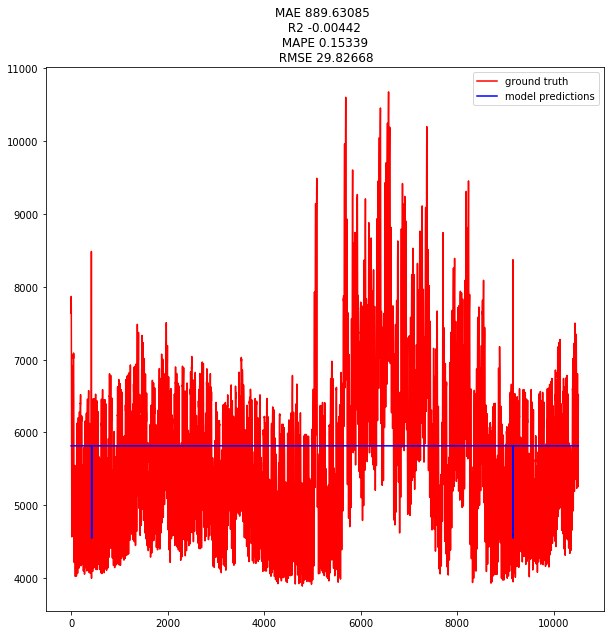

In [63]:
plt.figure(figsize=(10,10))
plt.title("MAE %.5f \n R2 %.5f \n MAPE %.5f \n RMSE %.5f"%(mean_absolute_error(test,pred), r2_score(test,pred), np.mean(np.abs(test-pred)/test), np.sqrt(mean_absolute_error(test,pred))))
plt.plot(test, color='r', label='ground truth')
plt.plot(pred, color='b', label='model predictions')
plt.legend()
plt.show()

In [64]:
fut_train1 = np.zeros_like(fut_train)
pred = model.predict([past_train, fut_train1], batch_size=32)
lin_model = linear_regression(pred, y_train)
pred1 = model.predict([past_test, fut_test])
pred = lin_model.predict(pred1)
pred = np.array(pred).reshape((-1,))
test = y_test.reshape((-1,))

MAE 1109.8475
R2 -0.0299
RMSE 1436.9639


(10512,) (10512,)


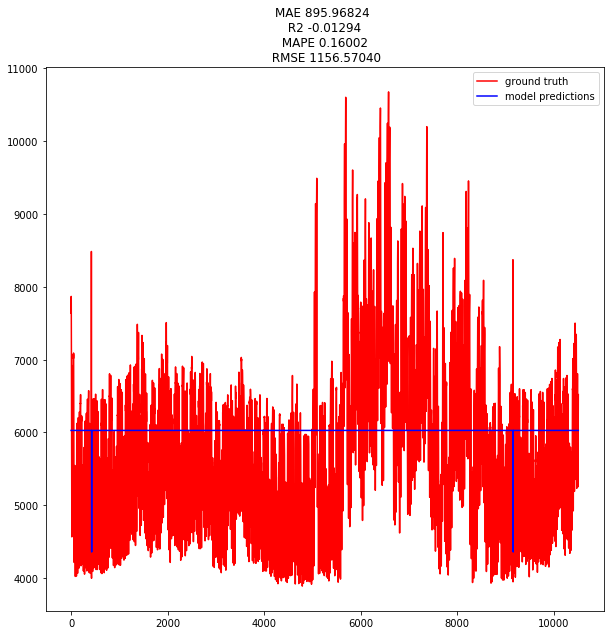

In [65]:
print(pred.shape, test.shape)
plt.figure(figsize=(10,10))
plt.title("MAE %.5f \n R2 %.5f \n MAPE %.5f \n RMSE %.5f"%(mean_absolute_error(test,pred), r2_score(test,pred), np.mean(np.abs(test-pred)/test), np.sqrt(mean_squared_error(test,pred))))
plt.plot(test, color='r', label='ground truth')
plt.plot(pred, color='b', label='model predictions')
plt.legend()
plt.show()

In [92]:
model_pred = model.predict([past_test,past_test], batch_size=32).reshape((-1,1))
linear_pred = pred.reshape((-1,1))
ground_true = test.reshape((-1,1))
results = pd.DataFrame(np.concatenate((ground_true,model_pred,linear_pred),axis=1),columns=['Ground turth', 'Model Predictions','Linear Reg'])
results.to_csv("Results/NYC Load Dataset distributed lstm results.csv",sep=',')

## Stock data

In [109]:
stocks = ['AMZN','FB','WMT']
stock = stocks[2]
data = pd.read_csv("all_stocks_5yr.csv")
data = data[data['Name'] == stock][['close']].reset_index(drop=True)
data = (data - data.mean()) / (data.std())

In [110]:
time_steps = 21
num_features = 0
past,fut,y = create_formatted_data(data, time_steps, num_features)
past_train, past_test, fut_train, fut_test, y_train, y_test = train_test_split(past,fut,y,data)

In [111]:
model = distributed_lstm_model(past.shape[1:], fut.shape[1:])
callbacks = [EarlyStopping(monitor='loss',
                              min_delta=0.5,
                              patience=80,
                              verbose=0, mode='auto')]
history_callback = model.fit([past_train, fut_train], y_train, epochs=500, batch_size=256, validation_data=([past_test,fut_test], y_test))

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_21 (InputLayer)           (None, 10, 1)        0                                            
__________________________________________________________________________________________________
input_22 (InputLayer)           (None, 10, 1)        0                                            
__________________________________________________________________________________________________
lstm_29 (LSTM)                  (None, 10, 8)        320         input_21[0][0]                   
__________________________________________________________________________________________________
lstm_30 (LSTM)                  (None, 10, 8)        320         input_22[0][0]                   
__________________________________________________________________________________________________
average_11

Epoch 25/500
990/990 [==============================] - 0s 38us/step - loss: 0.2016 - mean_absolute_error: 0.4994 - rmse: 0.4994 - val_loss: 0.5782 - val_mean_absolute_error: 0.9497 - val_rmse: 0.9497
Epoch 26/500
990/990 [==============================] - 0s 37us/step - loss: 0.1943 - mean_absolute_error: 0.4872 - rmse: 0.4872 - val_loss: 0.5529 - val_mean_absolute_error: 0.9215 - val_rmse: 0.9215
Epoch 27/500
990/990 [==============================] - 0s 37us/step - loss: 0.1875 - mean_absolute_error: 0.4776 - rmse: 0.4776 - val_loss: 0.5253 - val_mean_absolute_error: 0.8904 - val_rmse: 0.8904
Epoch 28/500
990/990 [==============================] - 0s 40us/step - loss: 0.1778 - mean_absolute_error: 0.4600 - rmse: 0.4600 - val_loss: 0.4959 - val_mean_absolute_error: 0.8578 - val_rmse: 0.8578
Epoch 29/500
990/990 [==============================] - 0s 41us/step - loss: 0.1715 - mean_absolute_error: 0.4445 - rmse: 0.4445 - val_loss: 0.4694 - val_mean_absolute_error: 0.8286 - val_rmse: 0.

Epoch 66/500
990/990 [==============================] - 0s 37us/step - loss: 0.1058 - mean_absolute_error: 0.3375 - rmse: 0.3375 - val_loss: 0.3775 - val_mean_absolute_error: 0.7443 - val_rmse: 0.7443
Epoch 67/500
990/990 [==============================] - 0s 37us/step - loss: 0.1049 - mean_absolute_error: 0.3393 - rmse: 0.3393 - val_loss: 0.3783 - val_mean_absolute_error: 0.7453 - val_rmse: 0.7453
Epoch 68/500
990/990 [==============================] - 0s 37us/step - loss: 0.1030 - mean_absolute_error: 0.3373 - rmse: 0.3373 - val_loss: 0.3770 - val_mean_absolute_error: 0.7439 - val_rmse: 0.7439
Epoch 69/500
990/990 [==============================] - 0s 37us/step - loss: 0.1029 - mean_absolute_error: 0.3356 - rmse: 0.3356 - val_loss: 0.3747 - val_mean_absolute_error: 0.7413 - val_rmse: 0.7413
Epoch 70/500
990/990 [==============================] - 0s 37us/step - loss: 0.0999 - mean_absolute_error: 0.3280 - rmse: 0.3280 - val_loss: 0.3745 - val_mean_absolute_error: 0.7412 - val_rmse: 0.

Epoch 107/500
990/990 [==============================] - 0s 39us/step - loss: 0.0813 - mean_absolute_error: 0.3008 - rmse: 0.3008 - val_loss: 0.3520 - val_mean_absolute_error: 0.7153 - val_rmse: 0.7153
Epoch 108/500
990/990 [==============================] - 0s 38us/step - loss: 0.0806 - mean_absolute_error: 0.2989 - rmse: 0.2989 - val_loss: 0.3510 - val_mean_absolute_error: 0.7140 - val_rmse: 0.7140
Epoch 109/500
990/990 [==============================] - 0s 39us/step - loss: 0.0791 - mean_absolute_error: 0.2961 - rmse: 0.2961 - val_loss: 0.3496 - val_mean_absolute_error: 0.7123 - val_rmse: 0.7123
Epoch 110/500
990/990 [==============================] - 0s 38us/step - loss: 0.0793 - mean_absolute_error: 0.2998 - rmse: 0.2998 - val_loss: 0.3490 - val_mean_absolute_error: 0.7115 - val_rmse: 0.7115
Epoch 111/500
990/990 [==============================] - 0s 37us/step - loss: 0.0796 - mean_absolute_error: 0.2976 - rmse: 0.2976 - val_loss: 0.3502 - val_mean_absolute_error: 0.7128 - val_rms

Epoch 188/500
990/990 [==============================] - 0s 40us/step - loss: 0.0581 - mean_absolute_error: 0.2612 - rmse: 0.2612 - val_loss: 0.3438 - val_mean_absolute_error: 0.6999 - val_rmse: 0.6999
Epoch 189/500
990/990 [==============================] - 0s 40us/step - loss: 0.0574 - mean_absolute_error: 0.2548 - rmse: 0.2548 - val_loss: 0.3438 - val_mean_absolute_error: 0.6997 - val_rmse: 0.6997
Epoch 190/500
990/990 [==============================] - 0s 40us/step - loss: 0.0561 - mean_absolute_error: 0.2532 - rmse: 0.2532 - val_loss: 0.3436 - val_mean_absolute_error: 0.6994 - val_rmse: 0.6994
Epoch 191/500
990/990 [==============================] - 0s 40us/step - loss: 0.0551 - mean_absolute_error: 0.2499 - rmse: 0.2499 - val_loss: 0.3438 - val_mean_absolute_error: 0.6996 - val_rmse: 0.6996
Epoch 192/500
990/990 [==============================] - 0s 38us/step - loss: 0.0573 - mean_absolute_error: 0.2575 - rmse: 0.2575 - val_loss: 0.3438 - val_mean_absolute_error: 0.6995 - val_rms

Epoch 269/500
990/990 [==============================] - 0s 37us/step - loss: 0.0442 - mean_absolute_error: 0.2259 - rmse: 0.2259 - val_loss: 0.3394 - val_mean_absolute_error: 0.6890 - val_rmse: 0.6890
Epoch 270/500
990/990 [==============================] - 0s 37us/step - loss: 0.0461 - mean_absolute_error: 0.2344 - rmse: 0.2344 - val_loss: 0.3392 - val_mean_absolute_error: 0.6887 - val_rmse: 0.6887
Epoch 271/500
990/990 [==============================] - 0s 37us/step - loss: 0.0452 - mean_absolute_error: 0.2310 - rmse: 0.2310 - val_loss: 0.3387 - val_mean_absolute_error: 0.6880 - val_rmse: 0.6880
Epoch 272/500
990/990 [==============================] - 0s 38us/step - loss: 0.0464 - mean_absolute_error: 0.2343 - rmse: 0.2343 - val_loss: 0.3384 - val_mean_absolute_error: 0.6876 - val_rmse: 0.6876
Epoch 273/500
990/990 [==============================] - 0s 40us/step - loss: 0.0453 - mean_absolute_error: 0.2313 - rmse: 0.2313 - val_loss: 0.3384 - val_mean_absolute_error: 0.6876 - val_rms

Epoch 350/500
990/990 [==============================] - 0s 38us/step - loss: 0.0389 - mean_absolute_error: 0.2186 - rmse: 0.2186 - val_loss: 0.3385 - val_mean_absolute_error: 0.6834 - val_rmse: 0.6834
Epoch 351/500
990/990 [==============================] - 0s 39us/step - loss: 0.0372 - mean_absolute_error: 0.2099 - rmse: 0.2099 - val_loss: 0.3386 - val_mean_absolute_error: 0.6834 - val_rmse: 0.6834
Epoch 352/500
990/990 [==============================] - 0s 38us/step - loss: 0.0373 - mean_absolute_error: 0.2119 - rmse: 0.2119 - val_loss: 0.3385 - val_mean_absolute_error: 0.6833 - val_rmse: 0.6833
Epoch 353/500
990/990 [==============================] - 0s 37us/step - loss: 0.0388 - mean_absolute_error: 0.2142 - rmse: 0.2142 - val_loss: 0.3383 - val_mean_absolute_error: 0.6829 - val_rmse: 0.6829
Epoch 354/500
990/990 [==============================] - 0s 37us/step - loss: 0.0414 - mean_absolute_error: 0.2220 - rmse: 0.2220 - val_loss: 0.3382 - val_mean_absolute_error: 0.6828 - val_rms

Epoch 431/500
990/990 [==============================] - 0s 37us/step - loss: 0.0349 - mean_absolute_error: 0.2066 - rmse: 0.2066 - val_loss: 0.3362 - val_mean_absolute_error: 0.6767 - val_rmse: 0.6767
Epoch 432/500
990/990 [==============================] - 0s 37us/step - loss: 0.0332 - mean_absolute_error: 0.1973 - rmse: 0.1973 - val_loss: 0.3361 - val_mean_absolute_error: 0.6765 - val_rmse: 0.6765
Epoch 433/500
990/990 [==============================] - 0s 37us/step - loss: 0.0342 - mean_absolute_error: 0.2034 - rmse: 0.2034 - val_loss: 0.3359 - val_mean_absolute_error: 0.6762 - val_rmse: 0.6762
Epoch 434/500
990/990 [==============================] - 0s 37us/step - loss: 0.0352 - mean_absolute_error: 0.2070 - rmse: 0.2070 - val_loss: 0.3359 - val_mean_absolute_error: 0.6761 - val_rmse: 0.6761
Epoch 435/500
990/990 [==============================] - 0s 38us/step - loss: 0.0345 - mean_absolute_error: 0.2042 - rmse: 0.2042 - val_loss: 0.3359 - val_mean_absolute_error: 0.6761 - val_rms

In [112]:
history = {}
for key in (history_callback.history.keys()):
    history[str(key)] = history_callback.history[str(key)]

In [113]:
pred = model.predict([past_test, fut_test], batch_size=32)
pred = np.array(pred).reshape((-1,))
test = y_test.reshape((-1,))

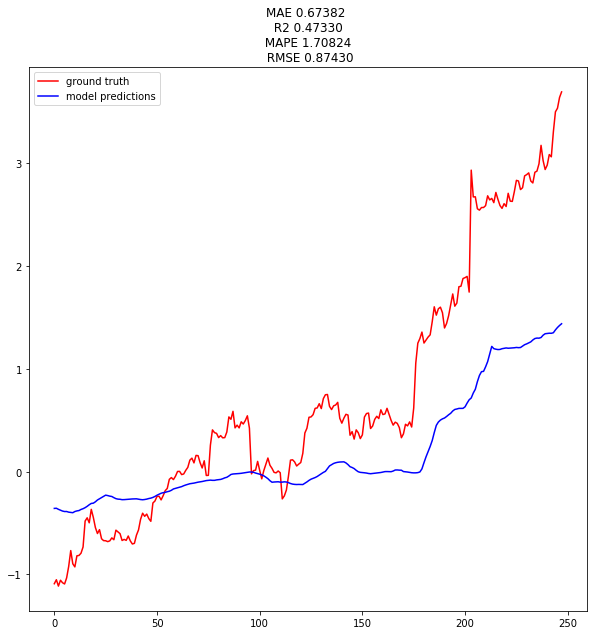

In [114]:
plt.figure(figsize=(10,10))
plt.title("MAE %.5f \n R2 %.5f \n MAPE %.5f \n RMSE %.5f"%(mean_absolute_error(test,pred), r2_score(test,pred), np.mean(np.abs(test-pred)/test), np.sqrt(mean_squared_error(test,pred))))
plt.plot(test, color='r', label='ground truth')
plt.plot(pred, color='b', label='model predictions')
plt.legend()
plt.show()

In [115]:
fut_train1 = np.zeros_like(fut_train)
pred = model.predict([past_train, fut_train1], batch_size=32)
lin_model = linear_regression(pred, y_train)
pred1 = model.predict([past_test, fut_test])
pred = lin_model.predict(pred1)
pred = np.array(pred).reshape((-1,))
test = y_test.reshape((-1,))

MAE 0.1678
R2 0.7893
RMSE 0.2161


In [116]:
lin_model.coef_

array([2.7819903], dtype=float32)

(248,) (248,)


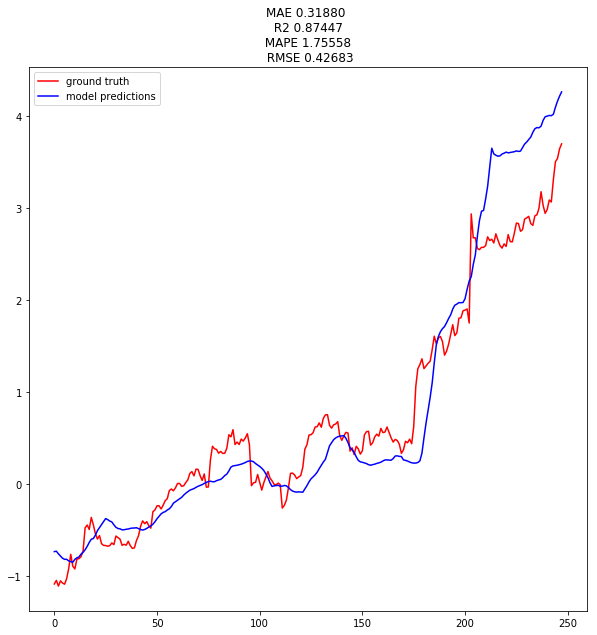

In [118]:
print(pred.shape, test.shape)
plt.figure(figsize=(10,10))
plt.title("MAE %.5f \n R2 %.5f \n MAPE %.5f \n RMSE %.5f"%(mean_absolute_error(test,pred), r2_score(test,pred), np.mean(np.abs(test-pred)/test), np.sqrt(mean_squared_error(test,pred))))
plt.plot(test, color='r', label='ground truth')
plt.plot(pred, color='b', label='model predictions')
plt.legend()
plt.show()

In [119]:
model_pred = model.predict([past_test,fut_test], batch_size=32).reshape((-1,1))
linear_pred = pred.reshape((-1,1))
ground_true = test.reshape((-1,1))
results = pd.DataFrame(np.concatenate((ground_true,model_pred,linear_pred),axis=1),columns=['Ground truth', 'Model Predictions','Linear Reg'])
results.to_csv("Results/M2_V2_"+str(stock)+".csv",sep=',')

In [120]:
#Pickling the history object.
pkl.dump(history,open('Results/M2_V2_'+str(stock)+'.pkl','wb'))

## Jena Weather Data

In [124]:
data = pd.read_csv("Jena_time_series_data.csv")['T (degC)']
data.reset_index(drop=True,inplace=True)
data = (data - data.mean())/data.std()

In [125]:
time_steps = 21
num_features = 0
past,fut,y = create_formatted_data(data, time_steps, num_features)
past_train, past_test, fut_train, fut_test, y_train, y_test = train_test_split(past,fut,y,data)

In [126]:
model = distributed_lstm_model(past.shape[1:], fut.shape[1:])
callbacks = [EarlyStopping(monitor='loss',
                              min_delta=0.01,
                              patience=10,
                              verbose=0, mode='auto')]
history_callback = model.fit([past_train, fut_train], y_train, epochs=200, batch_size=32, validation_data=([past_test,fut_test], y_test),callbacks = callbacks)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_23 (InputLayer)           (None, 10, 1)        0                                            
__________________________________________________________________________________________________
input_24 (InputLayer)           (None, 10, 1)        0                                            
__________________________________________________________________________________________________
lstm_31 (LSTM)                  (None, 10, 8)        320         input_23[0][0]                   
__________________________________________________________________________________________________
lstm_32 (LSTM)                  (None, 10, 8)        320         input_24[0][0]                   
__________________________________________________________________________________________________
average_12

In [132]:
pred = model.predict([past_test, fut_test], batch_size=32)
pred = np.array(pred).reshape((-1,))
test = y_test.reshape((-1,))

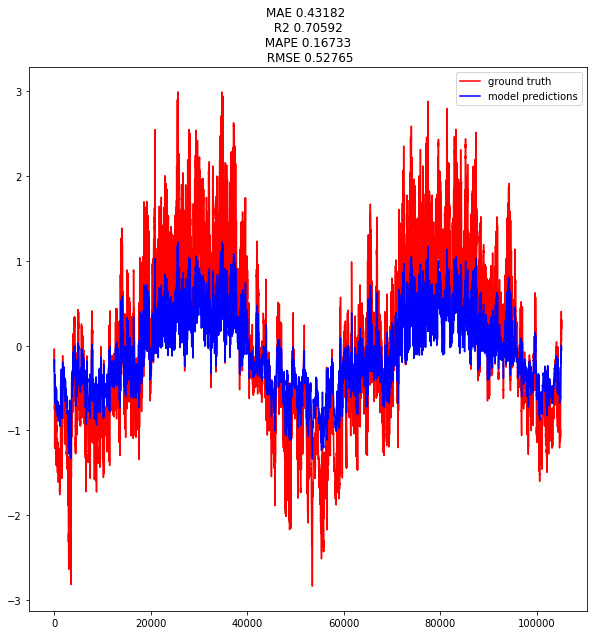

In [133]:
plt.figure(figsize=(10,10))
plt.title("MAE %.5f \n R2 %.5f \n MAPE %.5f \n RMSE %.5f"%(mean_absolute_error(test,pred), r2_score(test,pred), np.mean(np.abs(test-pred)/test), np.sqrt(mean_squared_error(test,pred))))
plt.plot(test, color='r', label='ground truth')
plt.plot(pred, color='b', label='model predictions')
plt.legend()
plt.show()

In [134]:
fut_train1 = np.zeros_like(fut_train)
pred = model.predict([past_train, fut_train1], batch_size=32)
lin_model = linear_regression(pred, y_train)
pred1 = model.predict([past_test, fut_test])
pred = lin_model.predict(pred1)
pred = np.array(pred).reshape((-1,))
test = y_test.reshape((-1,))

MAE 0.0912
R2 0.9798
RMSE 0.1265


In [135]:
lin_model.coef_

array([2.0723505], dtype=float32)

(105159,) (105159,)


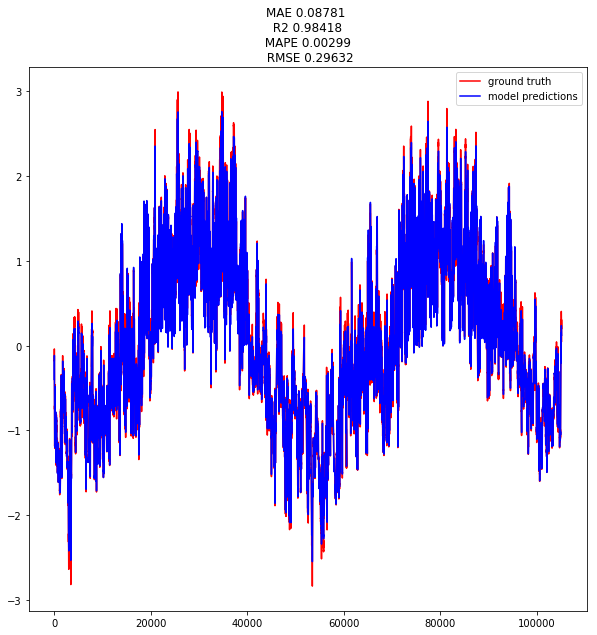

In [136]:
print(pred.shape, test.shape)
plt.figure(figsize=(10,10))
plt.title("MAE %.5f \n R2 %.5f \n MAPE %.5f \n RMSE %.5f"%(mean_absolute_error(test,pred), r2_score(test,pred), np.mean(np.abs(test-pred)/test), np.sqrt(mean_absolute_error(test,pred))))
plt.plot(test, color='r', label='ground truth')
plt.plot(pred, color='b', label='model predictions')
plt.legend()
plt.show()

In [137]:
model_pred = model.predict([past_test,fut_test], batch_size=32).reshape((-1,1))
linear_pred = pred.reshape((-1,1))
ground_true = test.reshape((-1,1))
results = pd.DataFrame(np.concatenate((ground_true,model_pred,linear_pred),axis=1),columns=['Ground truth', 'Model Predictions','Linear Reg'])
results.to_csv("Results/M2_V2_Jena Dataset.csv",sep=',')

In [138]:
history = {}
for key in (history_callback.history.keys()):
    history[str(key)] = history_callback.history[str(key)]

In [139]:
#Pickling the history object.
pkl.dump(history,open('Results/M2_V2_Jena.pkl','wb'))

## Zuerich Sunspot Data 

In [9]:
data = pd.read_csv("monthly-sunspot-number-zurich-17.csv")['Monthly sunspot number, Zurich, 1749-1983']

In [10]:
time_steps = 21
num_features = 0
past,fut,y = create_formatted_data(data, time_steps, num_features)
past_train, past_test, fut_train, fut_test, y_train, y_test = train_test_split(past,fut,y,data)

In [11]:
model = distributed_lstm_model(past.shape[1:], fut.shape[1:])
model.fit([past_train, fut_train], y_train, epochs=20, batch_size=32, validation_data=([past_test,fut_test], y_test))

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 10, 1)        0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 10, 1)        0                                            
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 6, 128)       768         input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_3 (Conv1D)               (None, 6, 128)       768         input_2[0][0]                    
__________________________________________________________________________________________________
conv1d_2 (

Train on 2239 samples, validate on 560 samples
Epoch 1/20
2239/2239 [==============================] - 11s 5ms/step - loss: 13.3293 - mean_absolute_error: 13.8182 - rmse: 13.8182 - val_loss: 41.8325 - val_mean_absolute_error: 42.3274 - val_rmse: 42.3274
Epoch 2/20
2239/2239 [==============================] - 4s 2ms/step - loss: 9.4341 - mean_absolute_error: 9.9162 - rmse: 9.9162 - val_loss: 37.2086 - val_mean_absolute_error: 37.7024 - val_rmse: 37.7024
Epoch 3/20
2239/2239 [==============================] - 4s 2ms/step - loss: 9.4695 - mean_absolute_error: 9.9539 - rmse: 9.9539 - val_loss: 40.4769 - val_mean_absolute_error: 40.9719 - val_rmse: 40.9719
Epoch 4/20
2239/2239 [==============================] - 4s 2ms/step - loss: 9.0967 - mean_absolute_error: 9.5761 - rmse: 9.5761 - val_loss: 37.6898 - val_mean_absolute_error: 38.1842 - val_rmse: 38.1842
Epoch 5/20
2239/2239 [==============================] - 4s 2ms/step - loss: 9.3232 - mean_absolute_error: 9.8046 - rmse: 9.8046 - val_los

In [12]:
pred = model.predict([past_test, fut_test], batch_size=32)
pred = np.array(pred).reshape((-1,))
test = y_test.reshape((-1,))

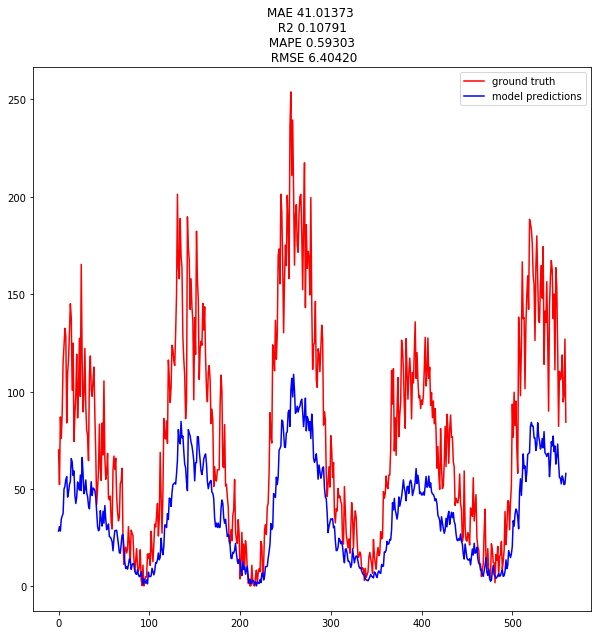

In [13]:
plt.figure(figsize=(10,10))
plt.title("MAE %.5f \n R2 %.5f \n MAPE %.5f \n RMSE %.5f"%(mean_absolute_error(test,pred), r2_score(test,pred), np.mean(np.abs(test-pred)/test), np.sqrt(mean_absolute_error(test,pred))))
plt.plot(test, color='r', label='ground truth')
plt.plot(pred, color='b', label='model predictions')
plt.legend()
plt.show()

In [14]:
fut_train1 = np.zeros_like(fut_train)
pred = model.predict([past_train, fut_train1], batch_size=32)
lin_model = linear_regression(pred, y_train)
pred1 = model.predict([past_test, fut_test])
pred = lin_model.predict(pred1)
pred = np.array(pred).reshape((-1,))
test = y_test.reshape((-1,))

MAE 10.0766
R2 0.7815
RMSE 13.7717


(560,) (560,)


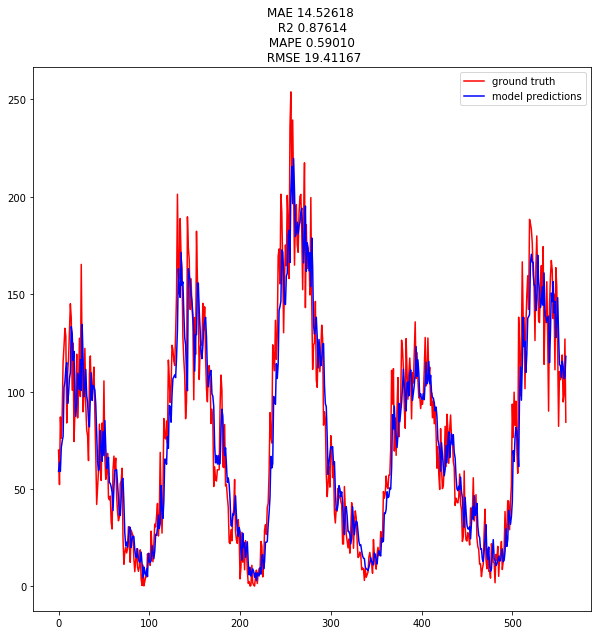

In [15]:
print(pred.shape, test.shape)
plt.figure(figsize=(10,10))
plt.title("MAE %.5f \n R2 %.5f \n MAPE %.5f \n RMSE %.5f"%(mean_absolute_error(test,pred), r2_score(test,pred), np.mean(np.abs(test-pred)/test), np.sqrt(mean_squared_error(test,pred))))
plt.plot(test, color='r', label='ground truth')
plt.plot(pred, color='b', label='model predictions')
plt.legend()
plt.show()

In [79]:
model_pred = model.predict([past_test,past_test], batch_size=32).reshape((-1,1))
linear_pred = pred.reshape((-1,1))
ground_true = test.reshape((-1,1))
results = pd.DataFrame(np.concatenate((ground_true,model_pred,linear_pred),axis=1),columns=['Ground turth', 'Model Predictions','Linear Reg'])
results.to_csv("Results/Zurich sunspot Dataset distributed lstm results.csv",sep=',')

# Combined LSTM

## NYC Load Data

In [40]:
data = pd.read_csv("NYC Load Data.csv")['Load']

In [41]:
time_steps = 73
num_features = 0
past,fut,y = create_formatted_data(data, time_steps, num_features)
past_train, past_test, fut_train, fut_test, y_train, y_test = train_test_split(past,fut,y,data)

In [42]:
model = common_lstm_model(past.shape[1:], fut.shape[1:])
callbacks = [EarlyStopping(monitor='loss',
                              min_delta=5,
                              patience=10,
                              verbose=0, mode='auto')]
history_callback = model.fit([past_train, fut_train], y_train, epochs=50, batch_size=32, validation_data=([past_test,fut_test], y_test),callbacks = callbacks)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            (None, 24, 1)        0                                            
__________________________________________________________________________________________________
input_10 (InputLayer)           (None, 24, 1)        0                                            
__________________________________________________________________________________________________
conv1d_17 (Conv1D)              (None, 20, 64)       384         input_9[0][0]                    
__________________________________________________________________________________________________
conv1d_19 (Conv1D)              (None, 20, 64)       384         input_10[0][0]                   
__________________________________________________________________________________________________
conv1d_18 

42004/42004 [==============================] - 13s 302us/step - loss: 727.2643 - mean_absolute_error: 727.7642 - rmse: 891.4238 - val_loss: 4230.1666 - val_mean_absolute_error: 4230.6666 - val_rmse: 4303.0772
Epoch 13/50
42004/42004 [==============================] - 13s 301us/step - loss: 729.3630 - mean_absolute_error: 729.8629 - rmse: 893.3442 - val_loss: 4129.3148 - val_mean_absolute_error: 4129.8148 - val_rmse: 4203.6289
Epoch 14/50
42004/42004 [==============================] - 13s 304us/step - loss: 724.7684 - mean_absolute_error: 725.2683 - rmse: 890.8949 - val_loss: 4339.0278 - val_mean_absolute_error: 4339.5278 - val_rmse: 4409.8031
Epoch 15/50
42004/42004 [==============================] - 13s 299us/step - loss: 726.6786 - mean_absolute_error: 727.1785 - rmse: 892.4493 - val_loss: 4180.1253 - val_mean_absolute_error: 4180.6253 - val_rmse: 4253.7775
Epoch 16/50
42004/42004 [==============================] - 13s 305us/step - loss: 723.6138 - mean_absolute_error: 724.1137 - rms

In [217]:
all_preds = []
temp_past_test = np.copy(past_test)
for i in range(1,past_test.shape[0]):
    pred = model.predict([temp_past_test[i,np.newaxis], fut_test[i,np.newaxis]], batch_size=32)
    temp_past_test[i+1][-1] = pred
    if (i%23 == 0):
        temp_past_test = np.copy(past_test)
        _ = model.fit([past_test[i-23:i], fut_train[i-23:i]], y_test[i-23:i], epochs=2, batch_size=32)
    all_preds.append(pred)

Epoch 1/2
23/23 [==============================] - 0s 422us/step - loss: 2448.8657 - mean_absolute_error: 2449.3657 - rmse: 2449.3657
Epoch 2/2
23/23 [==============================] - 0s 505us/step - loss: 1902.6151 - mean_absolute_error: 1903.1151 - rmse: 1903.1151
Epoch 1/2
23/23 [==============================] - 0s 365us/step - loss: 480.1081 - mean_absolute_error: 480.6081 - rmse: 480.6081
Epoch 2/2
23/23 [==============================] - 0s 379us/step - loss: 3024.4802 - mean_absolute_error: 3024.9802 - rmse: 3024.9802
Epoch 1/2
23/23 [==============================] - 0s 384us/step - loss: 1118.8391 - mean_absolute_error: 1119.3391 - rmse: 1119.3391
Epoch 2/2
23/23 [==============================] - 0s 422us/step - loss: 338.9635 - mean_absolute_error: 339.4635 - rmse: 339.4635
Epoch 1/2
23/23 [==============================] - 0s 408us/step - loss: 169.3674 - mean_absolute_error: 169.8674 - rmse: 169.8674
Epoch 2/2
23/23 [==============================] - 0s 436us/step - loss

Epoch 2/2
23/23 [==============================] - 0s 331us/step - loss: 145.8559 - mean_absolute_error: 146.3559 - rmse: 146.3559
Epoch 1/2
23/23 [==============================] - 0s 326us/step - loss: 650.1989 - mean_absolute_error: 650.6989 - rmse: 650.6989
Epoch 2/2
23/23 [==============================] - 0s 344us/step - loss: 675.9615 - mean_absolute_error: 676.4615 - rmse: 676.4614
Epoch 1/2
23/23 [==============================] - 0s 318us/step - loss: 308.9425 - mean_absolute_error: 309.4425 - rmse: 309.4425
Epoch 2/2
23/23 [==============================] - 0s 345us/step - loss: 286.8025 - mean_absolute_error: 287.3025 - rmse: 287.3025
Epoch 1/2
23/23 [==============================] - 0s 335us/step - loss: 927.8465 - mean_absolute_error: 928.3465 - rmse: 928.3465
Epoch 2/2
23/23 [==============================] - 0s 363us/step - loss: 788.1161 - mean_absolute_error: 788.6161 - rmse: 788.6161
Epoch 1/2
23/23 [==============================] - 0s 419us/step - loss: 685.7561 -

Epoch 1/2
23/23 [==============================] - 0s 344us/step - loss: 996.0554 - mean_absolute_error: 996.5554 - rmse: 996.5554
Epoch 2/2
23/23 [==============================] - 0s 366us/step - loss: 1131.4131 - mean_absolute_error: 1131.9131 - rmse: 1131.9131
Epoch 1/2
23/23 [==============================] - 0s 355us/step - loss: 1413.2159 - mean_absolute_error: 1413.7159 - rmse: 1413.7159
Epoch 2/2
23/23 [==============================] - 0s 335us/step - loss: 1162.8875 - mean_absolute_error: 1163.3875 - rmse: 1163.3875
Epoch 1/2
23/23 [==============================] - 0s 392us/step - loss: 726.0917 - mean_absolute_error: 726.5917 - rmse: 726.5917
Epoch 2/2
23/23 [==============================] - 0s 382us/step - loss: 251.9935 - mean_absolute_error: 252.4935 - rmse: 252.4935
Epoch 1/2
23/23 [==============================] - 0s 358us/step - loss: 1201.9496 - mean_absolute_error: 1202.4496 - rmse: 1202.4496
Epoch 2/2
23/23 [==============================] - 0s 427us/step - loss

Epoch 2/2
23/23 [==============================] - 0s 444us/step - loss: 303.0696 - mean_absolute_error: 303.5696 - rmse: 303.5696
Epoch 1/2
23/23 [==============================] - 0s 410us/step - loss: 554.5193 - mean_absolute_error: 555.0193 - rmse: 555.0193
Epoch 2/2
23/23 [==============================] - 0s 423us/step - loss: 608.9195 - mean_absolute_error: 609.4195 - rmse: 609.4195
Epoch 1/2
23/23 [==============================] - 0s 434us/step - loss: 626.7211 - mean_absolute_error: 627.2211 - rmse: 627.2211
Epoch 2/2
23/23 [==============================] - 0s 442us/step - loss: 269.9199 - mean_absolute_error: 270.4199 - rmse: 270.4199
Epoch 1/2
23/23 [==============================] - 0s 423us/step - loss: 158.7045 - mean_absolute_error: 159.2045 - rmse: 159.2045
Epoch 2/2
23/23 [==============================] - 0s 407us/step - loss: 371.0238 - mean_absolute_error: 371.5238 - rmse: 371.5238
Epoch 1/2
23/23 [==============================] - 0s 337us/step - loss: 207.2702 -

Epoch 1/2
23/23 [==============================] - 0s 328us/step - loss: 330.2452 - mean_absolute_error: 330.7452 - rmse: 330.7452
Epoch 2/2
23/23 [==============================] - 0s 424us/step - loss: 130.4537 - mean_absolute_error: 130.9429 - rmse: 130.9429
Epoch 1/2
23/23 [==============================] - 0s 382us/step - loss: 166.4741 - mean_absolute_error: 166.9741 - rmse: 166.9741
Epoch 2/2
23/23 [==============================] - 0s 345us/step - loss: 232.8586 - mean_absolute_error: 233.3586 - rmse: 233.3586
Epoch 1/2
23/23 [==============================] - 0s 350us/step - loss: 221.3931 - mean_absolute_error: 221.8724 - rmse: 221.8724
Epoch 2/2
23/23 [==============================] - 0s 384us/step - loss: 287.8652 - mean_absolute_error: 288.3652 - rmse: 288.3652
Epoch 1/2
23/23 [==============================] - 0s 359us/step - loss: 415.8669 - mean_absolute_error: 416.3669 - rmse: 416.3669
Epoch 2/2
23/23 [==============================] - 0s 398us/step - loss: 297.3420 -

Epoch 2/2
23/23 [==============================] - 0s 305us/step - loss: 608.9807 - mean_absolute_error: 609.4807 - rmse: 609.4807
Epoch 1/2
23/23 [==============================] - 0s 288us/step - loss: 990.0365 - mean_absolute_error: 990.5365 - rmse: 990.5365
Epoch 2/2
23/23 [==============================] - 0s 301us/step - loss: 697.9399 - mean_absolute_error: 698.4399 - rmse: 698.4399
Epoch 1/2
23/23 [==============================] - 0s 294us/step - loss: 561.0527 - mean_absolute_error: 561.5527 - rmse: 561.5527
Epoch 2/2
23/23 [==============================] - 0s 330us/step - loss: 214.2321 - mean_absolute_error: 214.7321 - rmse: 214.7321
Epoch 1/2
23/23 [==============================] - 0s 313us/step - loss: 356.8880 - mean_absolute_error: 357.3880 - rmse: 357.3880
Epoch 2/2
23/23 [==============================] - 0s 313us/step - loss: 598.3578 - mean_absolute_error: 598.8578 - rmse: 598.8578
Epoch 1/2
23/23 [==============================] - 0s 371us/step - loss: 797.3021 -

Epoch 1/2
23/23 [==============================] - 0s 400us/step - loss: 295.6772 - mean_absolute_error: 296.1772 - rmse: 296.1772
Epoch 2/2
23/23 [==============================] - 0s 380us/step - loss: 296.5548 - mean_absolute_error: 297.0548 - rmse: 297.0548
Epoch 1/2
23/23 [==============================] - 0s 385us/step - loss: 263.5756 - mean_absolute_error: 264.0756 - rmse: 264.0756
Epoch 2/2
23/23 [==============================] - 0s 412us/step - loss: 262.1894 - mean_absolute_error: 262.6894 - rmse: 262.6894
Epoch 1/2
23/23 [==============================] - 0s 338us/step - loss: 214.6550 - mean_absolute_error: 215.1550 - rmse: 215.1550
Epoch 2/2
23/23 [==============================] - 0s 356us/step - loss: 179.0365 - mean_absolute_error: 179.5365 - rmse: 179.5365
Epoch 1/2
23/23 [==============================] - 0s 304us/step - loss: 210.6501 - mean_absolute_error: 211.1501 - rmse: 211.1501
Epoch 2/2
23/23 [==============================] - 0s 355us/step - loss: 126.8608 -

Epoch 2/2
23/23 [==============================] - 0s 443us/step - loss: 265.5649 - mean_absolute_error: 266.0649 - rmse: 266.0649
Epoch 1/2
23/23 [==============================] - 0s 347us/step - loss: 337.0141 - mean_absolute_error: 337.5141 - rmse: 337.5141
Epoch 2/2
23/23 [==============================] - 0s 357us/step - loss: 318.9897 - mean_absolute_error: 319.4897 - rmse: 319.4897
Epoch 1/2
23/23 [==============================] - 0s 406us/step - loss: 1341.1853 - mean_absolute_error: 1341.6853 - rmse: 1341.6853
Epoch 2/2
23/23 [==============================] - 0s 430us/step - loss: 999.3698 - mean_absolute_error: 999.8698 - rmse: 999.8698
Epoch 1/2
23/23 [==============================] - 0s 402us/step - loss: 862.4603 - mean_absolute_error: 862.9603 - rmse: 862.9603
Epoch 2/2
23/23 [==============================] - 0s 392us/step - loss: 295.7828 - mean_absolute_error: 296.2828 - rmse: 296.2828
Epoch 1/2
23/23 [==============================] - 0s 431us/step - loss: 783.826

Epoch 1/2
23/23 [==============================] - 0s 428us/step - loss: 1391.5321 - mean_absolute_error: 1392.0321 - rmse: 1392.0321
Epoch 2/2
23/23 [==============================] - 0s 406us/step - loss: 1417.0186 - mean_absolute_error: 1417.5186 - rmse: 1417.5186
Epoch 1/2
23/23 [==============================] - 0s 410us/step - loss: 1956.1223 - mean_absolute_error: 1956.6223 - rmse: 1956.6223
Epoch 2/2
23/23 [==============================] - 0s 409us/step - loss: 1664.2184 - mean_absolute_error: 1664.7183 - rmse: 1664.7180
Epoch 1/2
23/23 [==============================] - 0s 331us/step - loss: 982.0090 - mean_absolute_error: 982.5090 - rmse: 982.5090
Epoch 2/2
23/23 [==============================] - 0s 367us/step - loss: 517.9540 - mean_absolute_error: 518.4540 - rmse: 518.4540
Epoch 1/2
23/23 [==============================] - 0s 349us/step - loss: 573.6307 - mean_absolute_error: 574.1307 - rmse: 574.1307
Epoch 2/2
23/23 [==============================] - 0s 349us/step - loss

Epoch 2/2
23/23 [==============================] - 0s 362us/step - loss: 2367.4797 - mean_absolute_error: 2367.9797 - rmse: 2367.9797
Epoch 1/2
23/23 [==============================] - 0s 358us/step - loss: 2513.9478 - mean_absolute_error: 2514.4478 - rmse: 2514.4478
Epoch 2/2
23/23 [==============================] - 0s 386us/step - loss: 2059.3406 - mean_absolute_error: 2059.8406 - rmse: 2059.8406
Epoch 1/2
23/23 [==============================] - 0s 316us/step - loss: 1335.8319 - mean_absolute_error: 1336.3319 - rmse: 1336.3319
Epoch 2/2
23/23 [==============================] - 0s 320us/step - loss: 312.7175 - mean_absolute_error: 313.2175 - rmse: 313.2175
Epoch 1/2
23/23 [==============================] - 0s 301us/step - loss: 1680.2972 - mean_absolute_error: 1680.7972 - rmse: 1680.7972
Epoch 2/2
23/23 [==============================] - 0s 301us/step - loss: 1334.7236 - mean_absolute_error: 1335.2236 - rmse: 1335.2236
Epoch 1/2
23/23 [==============================] - 0s 347us/step 

Epoch 1/2
23/23 [==============================] - 0s 356us/step - loss: 554.2145 - mean_absolute_error: 554.7145 - rmse: 554.7145
Epoch 2/2
23/23 [==============================] - 0s 470us/step - loss: 622.2125 - mean_absolute_error: 622.7125 - rmse: 622.7125
Epoch 1/2
23/23 [==============================] - 0s 359us/step - loss: 808.7587 - mean_absolute_error: 809.2587 - rmse: 809.2587
Epoch 2/2
23/23 [==============================] - 0s 351us/step - loss: 539.8900 - mean_absolute_error: 540.3900 - rmse: 540.3900
Epoch 1/2
23/23 [==============================] - 0s 367us/step - loss: 327.8284 - mean_absolute_error: 328.3284 - rmse: 328.3284
Epoch 2/2
23/23 [==============================] - 0s 342us/step - loss: 547.5792 - mean_absolute_error: 548.0792 - rmse: 548.0792
Epoch 1/2
23/23 [==============================] - 0s 333us/step - loss: 809.9156 - mean_absolute_error: 810.4156 - rmse: 810.4156
Epoch 2/2
23/23 [==============================] - 0s 367us/step - loss: 632.3437 -

Epoch 2/2
23/23 [==============================] - 0s 344us/step - loss: 85.3848 - mean_absolute_error: 85.8848 - rmse: 85.8848
Epoch 1/2
23/23 [==============================] - 0s 329us/step - loss: 191.2577 - mean_absolute_error: 191.7577 - rmse: 191.7577
Epoch 2/2
23/23 [==============================] - 0s 357us/step - loss: 375.0901 - mean_absolute_error: 375.5901 - rmse: 375.5901
Epoch 1/2
23/23 [==============================] - 0s 362us/step - loss: 721.2274 - mean_absolute_error: 721.7274 - rmse: 721.7274
Epoch 2/2
23/23 [==============================] - 0s 383us/step - loss: 656.8701 - mean_absolute_error: 657.3701 - rmse: 657.3701
Epoch 1/2
23/23 [==============================] - 0s 341us/step - loss: 647.4174 - mean_absolute_error: 647.9174 - rmse: 647.9174
Epoch 2/2
23/23 [==============================] - 0s 377us/step - loss: 398.2083 - mean_absolute_error: 398.7083 - rmse: 398.7083
Epoch 1/2
23/23 [==============================] - 0s 320us/step - loss: 324.3603 - me

Epoch 1/2
23/23 [==============================] - 0s 405us/step - loss: 486.0642 - mean_absolute_error: 486.5642 - rmse: 486.5642
Epoch 2/2
23/23 [==============================] - 0s 403us/step - loss: 395.7114 - mean_absolute_error: 396.2114 - rmse: 396.2114
Epoch 1/2
23/23 [==============================] - 0s 372us/step - loss: 378.1972 - mean_absolute_error: 378.6972 - rmse: 378.6972
Epoch 2/2
23/23 [==============================] - 0s 376us/step - loss: 276.7762 - mean_absolute_error: 277.2762 - rmse: 277.2762
Epoch 1/2
23/23 [==============================] - 0s 383us/step - loss: 241.2846 - mean_absolute_error: 241.7846 - rmse: 241.7846
Epoch 2/2
23/23 [==============================] - 0s 404us/step - loss: 329.2788 - mean_absolute_error: 329.7788 - rmse: 329.7788
Epoch 1/2
23/23 [==============================] - 0s 405us/step - loss: 310.9477 - mean_absolute_error: 311.4472 - rmse: 311.4472
Epoch 2/2
23/23 [==============================] - 0s 437us/step - loss: 306.0803 -

Epoch 2/2
23/23 [==============================] - 0s 362us/step - loss: 361.8367 - mean_absolute_error: 362.3367 - rmse: 362.3367
Epoch 1/2
23/23 [==============================] - 0s 365us/step - loss: 155.8702 - mean_absolute_error: 156.3702 - rmse: 156.3702
Epoch 2/2
23/23 [==============================] - 0s 396us/step - loss: 301.6857 - mean_absolute_error: 302.1857 - rmse: 302.1857
Epoch 1/2
23/23 [==============================] - 0s 377us/step - loss: 348.7716 - mean_absolute_error: 349.2716 - rmse: 349.2716
Epoch 2/2
23/23 [==============================] - 0s 407us/step - loss: 379.7555 - mean_absolute_error: 380.2555 - rmse: 380.2555
Epoch 1/2
23/23 [==============================] - 0s 353us/step - loss: 437.9248 - mean_absolute_error: 438.4248 - rmse: 438.4248
Epoch 2/2
23/23 [==============================] - 0s 465us/step - loss: 304.3422 - mean_absolute_error: 304.8422 - rmse: 304.8422
Epoch 1/2
23/23 [==============================] - 0s 379us/step - loss: 162.4800 -

Epoch 1/2
23/23 [==============================] - 0s 404us/step - loss: 628.8978 - mean_absolute_error: 629.3978 - rmse: 629.3978
Epoch 2/2
23/23 [==============================] - 0s 498us/step - loss: 424.5702 - mean_absolute_error: 425.0702 - rmse: 425.0702
Epoch 1/2
23/23 [==============================] - 0s 346us/step - loss: 196.2113 - mean_absolute_error: 196.7113 - rmse: 196.7113
Epoch 2/2
23/23 [==============================] - 0s 366us/step - loss: 142.8391 - mean_absolute_error: 143.3391 - rmse: 143.3391
Epoch 1/2
23/23 [==============================] - 0s 423us/step - loss: 488.3776 - mean_absolute_error: 488.8776 - rmse: 488.8776
Epoch 2/2
23/23 [==============================] - 0s 460us/step - loss: 604.3352 - mean_absolute_error: 604.8352 - rmse: 604.8352
Epoch 1/2
23/23 [==============================] - 0s 426us/step - loss: 731.2837 - mean_absolute_error: 731.7837 - rmse: 731.7837
Epoch 2/2
23/23 [==============================] - 0s 415us/step - loss: 683.6267 -

IndexError: index 10512 is out of bounds for axis 0 with size 10512

In [218]:
len(all_preds) , y_test.shape

(10510, (10512,))

In [220]:
seq_pred = np.array(all_preds).squeeze()

In [30]:
plt.figure(figsize=(10,10))
plt.title("MAE %.5f \n R2 %.5f \n MAPE %.5f \n RMSE %.5f"%(mean_absolute_error(test,pred1), r2_score(test,pred1), np.mean(np.abs(test-pred1)/test), np.sqrt(mean_squared_error(test,pred1))))
plt.plot(test[1:-1], color='r', label='ground truth')
plt.plot(pred, color='b', label='model predictions')
plt.legend()
plt.show()

ValueError: Found input variables with inconsistent numbers of samples: [252024, 10501]

<Figure size 720x720 with 0 Axes>

In [198]:
lin_model.coef_

array([1.9723988], dtype=float32)

MAE 857.6005
R2 0.4022
RMSE 1095.0729
(252024,) (252024,)


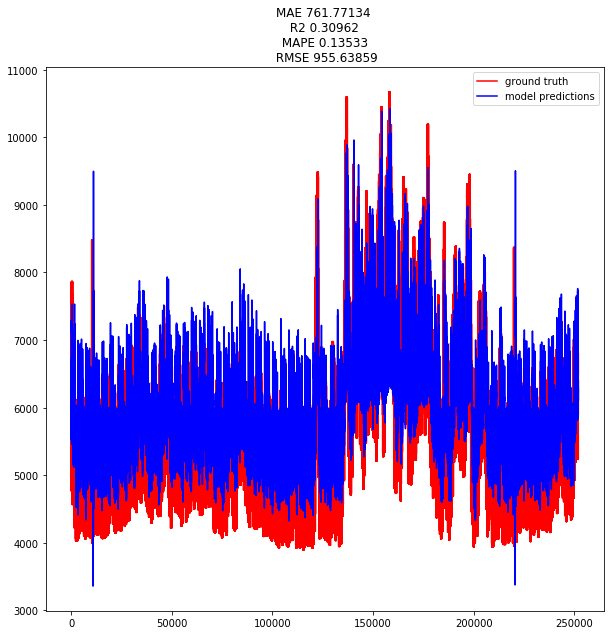

In [38]:
fut_train1 = np.zeros_like(fut_train)
lr_pred = model.predict([past_train, fut_train1], batch_size=32)
lin_model = linear_regression(lr_pred, y_train)
pred1 = model.predict([past_test, fut_test])
pred = lin_model.predict(pred1)
pred = np.array(pred).reshape((-1,))
test = y_test.reshape((-1,))

print(pred.shape, test.shape)
plt.figure(figsize=(10,10))
plt.title("MAE %.5f \n R2 %.5f \n MAPE %.5f \n RMSE %.5f"%(mean_absolute_error(test,pred), r2_score(test,pred), np.mean(np.abs(test-pred)/test), np.sqrt(mean_squared_error(test,pred))))
plt.plot(test, color='r', label='ground truth')
plt.plot(pred, color='b', label='model predictions')
plt.legend()
plt.show()

In [32]:
pred1 = model.predict([past_test, fut_test], batch_size=32)
pred1 = np.array(pred).reshape((-1,))
test = y_test.reshape((-1,))

In [27]:
model = common_lstm_model(past.shape[1:], fut.shape[1:])
callbacks = [EarlyStopping(monitor='loss',
                              min_delta=5,
                              patience=10,
                              verbose=0, mode='auto')]
history_callback = model.fit([past_train, fut_train], y_train, epochs=500, batch_size=32, validation_data=([past_test,fut_test], y_test),callbacks = callbacks)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 10, 1)        0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            (None, 10, 1)        0                                            
__________________________________________________________________________________________________
conv1d_9 (Conv1D)               (None, 6, 64)        384         input_5[0][0]                    
__________________________________________________________________________________________________
conv1d_11 (Conv1D)              (None, 6, 64)        384         input_6[0][0]                    
__________________________________________________________________________________________________
conv1d_10 

42026/42026 [==============================] - 9s 213us/step - loss: 336.1386 - mean_absolute_error: 336.6381 - rmse: 336.6381 - val_loss: 4473.7377 - val_mean_absolute_error: 4474.2377 - val_rmse: 4474.2377
Epoch 13/500
42026/42026 [==============================] - 9s 204us/step - loss: 331.9744 - mean_absolute_error: 332.4740 - rmse: 332.4740 - val_loss: 5458.1879 - val_mean_absolute_error: 5458.6879 - val_rmse: 5458.6879
Epoch 14/500
42026/42026 [==============================] - 9s 209us/step - loss: 332.0135 - mean_absolute_error: 332.5131 - rmse: 332.5131 - val_loss: 4814.9042 - val_mean_absolute_error: 4815.4042 - val_rmse: 4815.4041
Epoch 15/500
42026/42026 [==============================] - 9s 204us/step - loss: 326.0849 - mean_absolute_error: 326.5845 - rmse: 326.5845 - val_loss: 5414.6766 - val_mean_absolute_error: 5415.1766 - val_rmse: 5415.1765
Epoch 16/500
42026/42026 [==============================] - 9s 210us/step - loss: 324.5871 - mean_absolute_error: 325.0867 - rmse

In [28]:
history = {}
for key in (history_callback.history.keys()):
    history[str(key)] = history_callback.history[str(key)]

In [29]:
pred = model.predict([past_test, fut_test], batch_size=32)
pred = np.array(pred).reshape((-1,))
test = y_test.reshape((-1,))

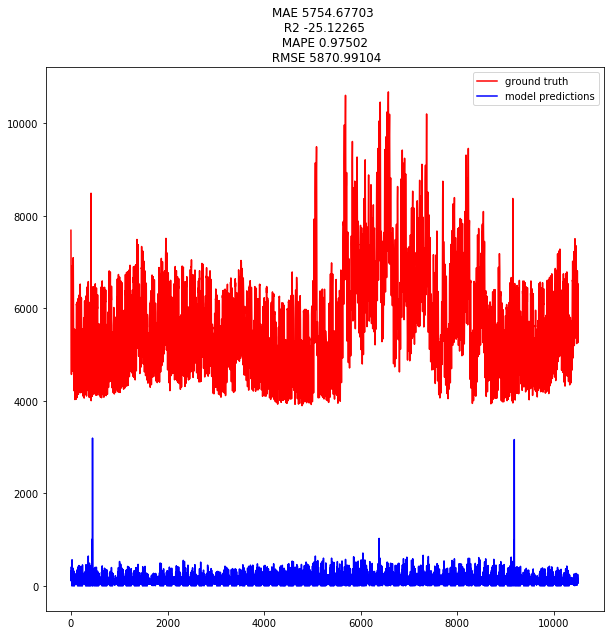

In [30]:
plt.figure(figsize=(10,10))
plt.title("MAE %.5f \n R2 %.5f \n MAPE %.5f \n RMSE %.5f"%(mean_absolute_error(test,pred), r2_score(test,pred), np.mean(np.abs(test-pred)/test), np.sqrt(mean_squared_error(test,pred))))
plt.plot(test, color='r', label='ground truth')
plt.plot(pred, color='b', label='model predictions')
plt.legend()
plt.show()

In [31]:
fut_train1 = np.zeros_like(fut_train)
pred = model.predict([past_train, fut_train1], batch_size=32)
lin_model = linear_regression(pred, y_train)
pred1 = model.predict([past_test, fut_test])
pred = lin_model.predict(pred1)
pred = np.array(pred).reshape((-1,))
test = y_test.reshape((-1,))

MAE 1112.2136
R2 -0.0328
RMSE 1439.3885


In [32]:
lin_model.coef_

array([-0.9992579], dtype=float32)

(10507,) (10507,)


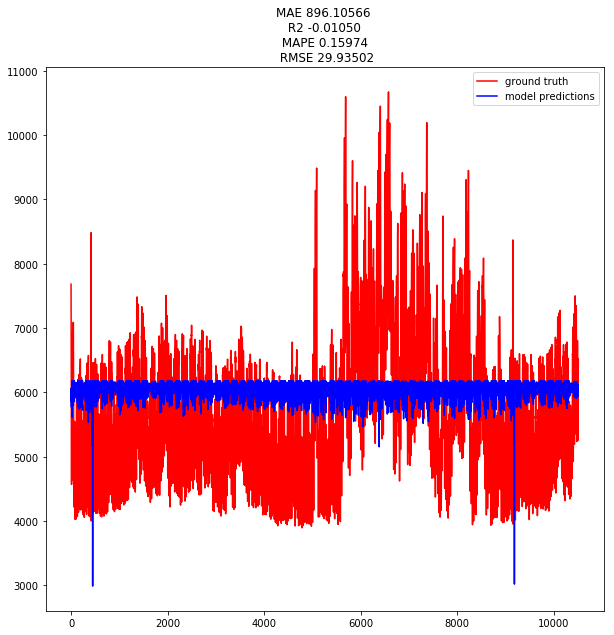

In [33]:
print(pred.shape, test.shape)
plt.figure(figsize=(10,10))
plt.title("MAE %.5f \n R2 %.5f \n MAPE %.5f \n RMSE %.5f"%(mean_absolute_error(test,pred), r2_score(test,pred), np.mean(np.abs(test-pred)/test), np.sqrt(mean_absolute_error(test,pred))))
plt.plot(test, color='r', label='ground truth')
plt.plot(pred, color='b', label='model predictions')
plt.legend()
plt.show()

In [18]:
model_pred = model.predict([past_test,fut_test], batch_size=32).reshape((-1,1))
linear_pred = pred.reshape((-1,1))
ground_true = test.reshape((-1,1))
results = pd.DataFrame(np.concatenate((ground_true,model_pred,linear_pred),axis=1),columns=['Ground truth', 'Model Predictions','Linear Reg'])
results.to_csv("Results/M1_V1_NYC Load Dataset combined lstm results.csv",sep=',')

In [19]:
#Pickling the history object.
pkl.dump(history,open('Results/M1_V1_NYC.pkl','wb'))

## Stock data

In [47]:
stocks = ['AMZN','FB','WMT']
stock = stocks[0]
data = pd.read_csv("all_3_stocks.csv")[stock].reset_index(drop=True)

In [48]:
time_steps = 21
num_features = 0
past,fut,y = create_formatted_data(data, time_steps, num_features)
past_train, past_test, fut_train, fut_test, y_train, y_test = train_test_split(past,fut,y,data)

In [49]:
past.shape[1:]

(10, 1)

In [50]:
model = common_lstm_model(past.shape[1:], fut.shape[1:])
callbacks = [EarlyStopping(monitor='loss',
                              min_delta=0.05,
                              patience=80,
                              verbose=0, mode='auto')]
history_callback = model.fit([past_train, fut_train], y_train, epochs=500, batch_size=32, validation_data=([past_test,fut_test], y_test),callbacks = callbacks)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, 10, 1)        0                                            
__________________________________________________________________________________________________
input_8 (InputLayer)            (None, 10, 1)        0                                            
__________________________________________________________________________________________________
conv1d_13 (Conv1D)              (None, 6, 16)        96          input_7[0][0]                    
__________________________________________________________________________________________________
conv1d_15 (Conv1D)              (None, 6, 16)        96          input_8[0][0]                    
__________________________________________________________________________________________________
conv1d_14 

Epoch 49/500
1235/1235 [==============================] - 0s 289us/step - loss: 14.2846 - mean_absolute_error: 14.7788 - rmse: 14.7788 - val_loss: 599.1850 - val_mean_absolute_error: 599.6850 - val_rmse: 599.6850
Epoch 50/500
1235/1235 [==============================] - 0s 298us/step - loss: 10.7753 - mean_absolute_error: 11.2603 - rmse: 11.2603 - val_loss: 572.0049 - val_mean_absolute_error: 572.5049 - val_rmse: 572.5049
Epoch 51/500
1235/1235 [==============================] - 0s 293us/step - loss: 13.7282 - mean_absolute_error: 14.2185 - rmse: 14.2185 - val_loss: 585.9299 - val_mean_absolute_error: 586.4299 - val_rmse: 586.4298
Epoch 52/500
1235/1235 [==============================] - 0s 292us/step - loss: 15.1180 - mean_absolute_error: 15.6107 - rmse: 15.6107 - val_loss: 535.8493 - val_mean_absolute_error: 536.3493 - val_rmse: 536.3493
Epoch 53/500
1235/1235 [==============================] - 0s 297us/step - loss: 25.3863 - mean_absolute_error: 25.8832 - rmse: 25.8832 - val_loss: 5

Epoch 88/500
1235/1235 [==============================] - 0s 297us/step - loss: 10.8514 - mean_absolute_error: 11.3412 - rmse: 11.3412 - val_loss: 571.4025 - val_mean_absolute_error: 571.9025 - val_rmse: 571.9025
Epoch 89/500
1235/1235 [==============================] - 0s 273us/step - loss: 8.1857 - mean_absolute_error: 8.6694 - rmse: 8.6694 - val_loss: 582.7667 - val_mean_absolute_error: 583.2667 - val_rmse: 583.2667
Epoch 90/500
1235/1235 [==============================] - 0s 279us/step - loss: 9.2487 - mean_absolute_error: 9.7359 - rmse: 9.7359 - val_loss: 563.1833 - val_mean_absolute_error: 563.6833 - val_rmse: 563.6833
Epoch 91/500
1235/1235 [==============================] - 0s 309us/step - loss: 5.8757 - mean_absolute_error: 6.3571 - rmse: 6.3571 - val_loss: 543.3890 - val_mean_absolute_error: 543.8890 - val_rmse: 543.8890
Epoch 92/500
1235/1235 [==============================] - 0s 313us/step - loss: 8.0120 - mean_absolute_error: 8.4960 - rmse: 8.4960 - val_loss: 584.3639 - va

Epoch 127/500
1235/1235 [==============================] - 0s 285us/step - loss: 11.5290 - mean_absolute_error: 12.0219 - rmse: 12.0219 - val_loss: 613.6305 - val_mean_absolute_error: 614.1305 - val_rmse: 614.1305
Epoch 128/500
1235/1235 [==============================] - 0s 289us/step - loss: 6.3124 - mean_absolute_error: 6.7936 - rmse: 6.7936 - val_loss: 618.7913 - val_mean_absolute_error: 619.2913 - val_rmse: 619.2913
Epoch 129/500
1235/1235 [==============================] - 0s 297us/step - loss: 7.3327 - mean_absolute_error: 7.8129 - rmse: 7.8129 - val_loss: 619.6054 - val_mean_absolute_error: 620.1054 - val_rmse: 620.1054
Epoch 130/500
1235/1235 [==============================] - 0s 303us/step - loss: 8.3629 - mean_absolute_error: 8.8542 - rmse: 8.8542 - val_loss: 601.1596 - val_mean_absolute_error: 601.6596 - val_rmse: 601.6596
Epoch 131/500
1235/1235 [==============================] - 0s 281us/step - loss: 8.1292 - mean_absolute_error: 8.6167 - rmse: 8.6167 - val_loss: 617.1229

Epoch 166/500
1235/1235 [==============================] - 0s 276us/step - loss: 12.4991 - mean_absolute_error: 12.9920 - rmse: 12.9920 - val_loss: 617.9490 - val_mean_absolute_error: 618.4490 - val_rmse: 618.4489
Epoch 167/500
1235/1235 [==============================] - 0s 286us/step - loss: 7.1845 - mean_absolute_error: 7.6705 - rmse: 7.6705 - val_loss: 631.4366 - val_mean_absolute_error: 631.9366 - val_rmse: 631.9365
Epoch 168/500
1235/1235 [==============================] - 0s 288us/step - loss: 5.0014 - mean_absolute_error: 5.4780 - rmse: 5.4780 - val_loss: 611.7492 - val_mean_absolute_error: 612.2492 - val_rmse: 612.2492
Epoch 169/500
1235/1235 [==============================] - 0s 314us/step - loss: 5.7770 - mean_absolute_error: 6.2557 - rmse: 6.2557 - val_loss: 619.6119 - val_mean_absolute_error: 620.1119 - val_rmse: 620.1118
Epoch 170/500
1235/1235 [==============================] - 0s 321us/step - loss: 5.4631 - mean_absolute_error: 5.9399 - rmse: 5.9399 - val_loss: 653.2771

Epoch 205/500
1235/1235 [==============================] - 0s 311us/step - loss: 12.6728 - mean_absolute_error: 13.1664 - rmse: 13.1664 - val_loss: 647.6646 - val_mean_absolute_error: 648.1646 - val_rmse: 648.1646
Epoch 206/500
1235/1235 [==============================] - 0s 281us/step - loss: 7.3673 - mean_absolute_error: 7.8493 - rmse: 7.8493 - val_loss: 636.3569 - val_mean_absolute_error: 636.8569 - val_rmse: 636.8569
Epoch 207/500
1235/1235 [==============================] - 0s 296us/step - loss: 6.3775 - mean_absolute_error: 6.8625 - rmse: 6.8625 - val_loss: 631.7758 - val_mean_absolute_error: 632.2758 - val_rmse: 632.2758
Epoch 208/500
1235/1235 [==============================] - 0s 295us/step - loss: 8.1591 - mean_absolute_error: 8.6442 - rmse: 8.6442 - val_loss: 626.6432 - val_mean_absolute_error: 627.1432 - val_rmse: 627.1432
Epoch 209/500
1235/1235 [==============================] - 0s 288us/step - loss: 6.3318 - mean_absolute_error: 6.8164 - rmse: 6.8164 - val_loss: 628.7410

Epoch 244/500
1235/1235 [==============================] - 0s 288us/step - loss: 5.9959 - mean_absolute_error: 6.4792 - rmse: 6.4792 - val_loss: 633.8603 - val_mean_absolute_error: 634.3603 - val_rmse: 634.3603
Epoch 245/500
1235/1235 [==============================] - 0s 287us/step - loss: 5.2616 - mean_absolute_error: 5.7424 - rmse: 5.7424 - val_loss: 648.7105 - val_mean_absolute_error: 649.2105 - val_rmse: 649.2105
Epoch 246/500
1235/1235 [==============================] - 0s 299us/step - loss: 5.4949 - mean_absolute_error: 5.9741 - rmse: 5.9741 - val_loss: 640.0436 - val_mean_absolute_error: 640.5436 - val_rmse: 640.5436
Epoch 247/500
1235/1235 [==============================] - 0s 288us/step - loss: 7.1910 - mean_absolute_error: 7.6763 - rmse: 7.6763 - val_loss: 632.6889 - val_mean_absolute_error: 633.1889 - val_rmse: 633.1889
Epoch 248/500
1235/1235 [==============================] - 0s 285us/step - loss: 7.6944 - mean_absolute_error: 8.1810 - rmse: 8.1810 - val_loss: 659.8043 - 

Epoch 283/500
1235/1235 [==============================] - 0s 279us/step - loss: 4.8733 - mean_absolute_error: 5.3451 - rmse: 5.3451 - val_loss: 670.2265 - val_mean_absolute_error: 670.7265 - val_rmse: 670.7265
Epoch 284/500
1235/1235 [==============================] - 0s 294us/step - loss: 9.0651 - mean_absolute_error: 9.5515 - rmse: 9.5515 - val_loss: 672.2022 - val_mean_absolute_error: 672.7022 - val_rmse: 672.7022
Epoch 285/500
1235/1235 [==============================] - 0s 299us/step - loss: 5.6960 - mean_absolute_error: 6.1775 - rmse: 6.1775 - val_loss: 664.9432 - val_mean_absolute_error: 665.4432 - val_rmse: 665.4432
Epoch 286/500
1235/1235 [==============================] - 0s 290us/step - loss: 5.7219 - mean_absolute_error: 6.2047 - rmse: 6.2047 - val_loss: 673.8081 - val_mean_absolute_error: 674.3081 - val_rmse: 674.3081
Epoch 287/500
1235/1235 [==============================] - 0s 292us/step - loss: 6.8690 - mean_absolute_error: 7.3507 - rmse: 7.3507 - val_loss: 654.7614 - 

In [51]:
history = {}
for key in (history_callback.history.keys()):
    history[str(key)] = history_callback.history[str(key)]

In [52]:
pred = model.predict([past_test, fut_test], batch_size=32)
pred = np.array(pred).reshape((-1,))
test = y_test.reshape((-1,))

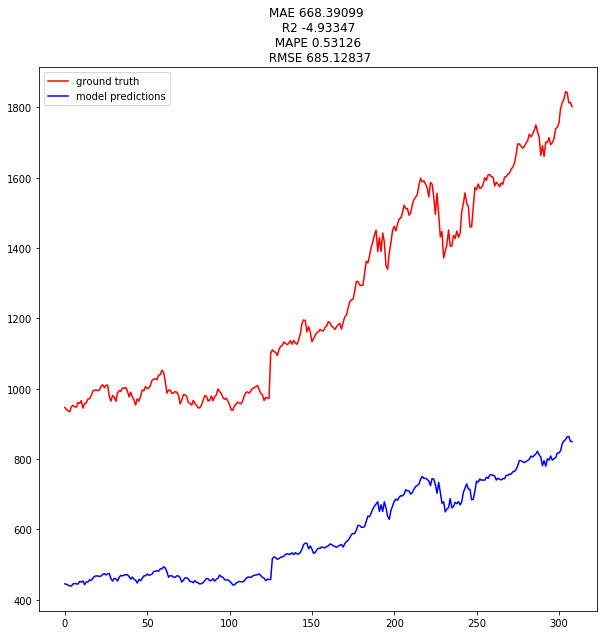

In [53]:
plt.figure(figsize=(10,10))
plt.title("MAE %.5f \n R2 %.5f \n MAPE %.5f \n RMSE %.5f"%(mean_absolute_error(test,pred), r2_score(test,pred), np.mean(np.abs(test-pred)/test), np.sqrt(mean_squared_error(test,pred))))
plt.plot(test, color='r', label='ground truth')
plt.plot(pred, color='b', label='model predictions')
plt.legend()
plt.show()

In [54]:
y_train.shape , pred.shape

((1235,), (309,))

In [55]:
fut_train1 = np.zeros_like(fut_train)
pred = model.predict([past_train, fut_train1], batch_size=32)
lin_model = linear_regression(pred, y_train)
pred1 = model.predict([past_test, fut_test])
pred = lin_model.predict(pred1)
pred = np.array(pred).reshape((-1,))
test = y_test.reshape((-1,))

MAE 7.8566
R2 0.9877
RMSE 11.2862


In [56]:
lin_model.coef_

array([2.1433141], dtype=float32)

(309,) (309,)


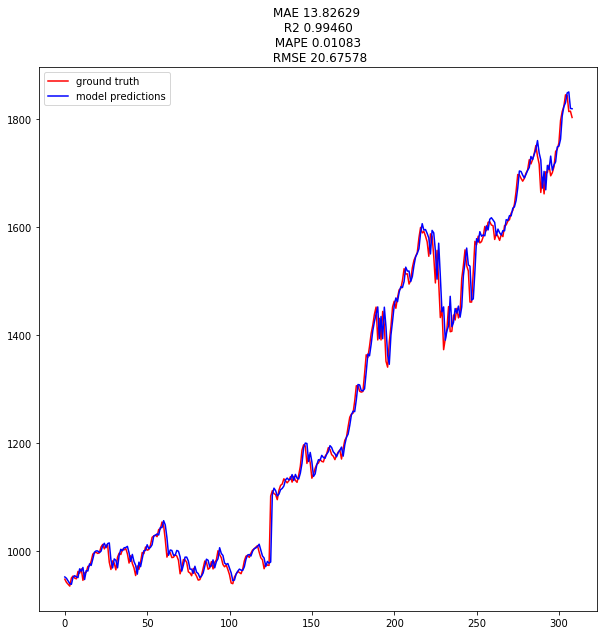

In [57]:
print(pred.shape, test.shape)
plt.figure(figsize=(10,10))
plt.title("MAE %.5f \n R2 %.5f \n MAPE %.5f \n RMSE %.5f"%(mean_absolute_error(test,pred), r2_score(test,pred), np.mean(np.abs(test-pred)/test), np.sqrt(mean_squared_error(test,pred))))
plt.plot(test, color='r', label='ground truth')
plt.plot(pred, color='b', label='model predictions')
plt.legend()
plt.show()

In [87]:
model_pred = model.predict([past_test,fut_test], batch_size=32).reshape((-1,1))
linear_pred = pred.reshape((-1,1))
ground_true = test.reshape((-1,1))
results = pd.DataFrame(np.concatenate((ground_true,model_pred,linear_pred),axis=1),columns=['Ground truth', 'Model Predictions','Linear Reg'])
results.to_csv("Results/M1_V1_red"+str(stock)+"_Stocks.csv",sep=',')

In [88]:
#Pickling the history object.
pkl.dump(history,open('Results/M1_V1_red'+str(stock)+'.pkl','wb'))

### Stacked LSTM

In [100]:
model = common_lstm_model(past.shape[1:], fut.shape[1:])
history_callback = model.fit([past_train, fut_train], y_train, epochs=150, batch_size=32, validation_data=([past_test,fut_test], y_test))

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_21 (InputLayer)           (None, 10, 1)        0                                            
__________________________________________________________________________________________________
input_22 (InputLayer)           (None, 10, 1)        0                                            
__________________________________________________________________________________________________
conv1d_41 (Conv1D)              (None, 6, 64)        384         input_21[0][0]                   
__________________________________________________________________________________________________
conv1d_43 (Conv1D)              (None, 6, 64)        384         input_22[0][0]                   
__________________________________________________________________________________________________
conv1d_42 

990/990 [==============================] - 0s 465us/step - loss: 1.3928 - mean_absolute_error: 1.8585 - rmse: 1.8585 - val_loss: 35.2164 - val_mean_absolute_error: 35.7164 - val_rmse: 35.7164
Epoch 49/150
990/990 [==============================] - 0s 454us/step - loss: 1.0321 - mean_absolute_error: 1.4640 - rmse: 1.4640 - val_loss: 32.5107 - val_mean_absolute_error: 33.0107 - val_rmse: 33.0107
Epoch 50/150
990/990 [==============================] - 0s 463us/step - loss: 1.0204 - mean_absolute_error: 1.4430 - rmse: 1.4430 - val_loss: 33.6549 - val_mean_absolute_error: 34.1549 - val_rmse: 34.1549
Epoch 51/150
990/990 [==============================] - 0s 479us/step - loss: 0.8996 - mean_absolute_error: 1.3160 - rmse: 1.3160 - val_loss: 34.0443 - val_mean_absolute_error: 34.5443 - val_rmse: 34.5443
Epoch 52/150
990/990 [==============================] - 0s 457us/step - loss: 1.3631 - mean_absolute_error: 1.8005 - rmse: 1.8005 - val_loss: 34.1530 - val_mean_absolute_error: 34.6530 - val_rm

990/990 [==============================] - 0s 466us/step - loss: 1.0184 - mean_absolute_error: 1.4511 - rmse: 1.4511 - val_loss: 35.0602 - val_mean_absolute_error: 35.5602 - val_rmse: 35.5602
Epoch 89/150
990/990 [==============================] - 0s 461us/step - loss: 1.9362 - mean_absolute_error: 2.3962 - rmse: 2.3962 - val_loss: 30.3149 - val_mean_absolute_error: 30.8149 - val_rmse: 30.8149
Epoch 90/150
990/990 [==============================] - 0s 448us/step - loss: 2.1398 - mean_absolute_error: 2.5847 - rmse: 2.5847 - val_loss: 32.7748 - val_mean_absolute_error: 33.2748 - val_rmse: 33.2748
Epoch 91/150
990/990 [==============================] - 0s 449us/step - loss: 0.9470 - mean_absolute_error: 1.3753 - rmse: 1.3753 - val_loss: 34.9361 - val_mean_absolute_error: 35.4361 - val_rmse: 35.4361
Epoch 92/150
990/990 [==============================] - 0s 459us/step - loss: 0.5082 - mean_absolute_error: 0.8937 - rmse: 0.8937 - val_loss: 33.2278 - val_mean_absolute_error: 33.7278 - val_rm

Epoch 128/150
990/990 [==============================] - 0s 466us/step - loss: 1.2026 - mean_absolute_error: 1.6455 - rmse: 1.6455 - val_loss: 34.5976 - val_mean_absolute_error: 35.0976 - val_rmse: 35.0976
Epoch 129/150
990/990 [==============================] - 0s 467us/step - loss: 1.4000 - mean_absolute_error: 1.8681 - rmse: 1.8681 - val_loss: 34.2823 - val_mean_absolute_error: 34.7823 - val_rmse: 34.7823
Epoch 130/150
990/990 [==============================] - 0s 459us/step - loss: 0.9056 - mean_absolute_error: 1.3431 - rmse: 1.3431 - val_loss: 34.1573 - val_mean_absolute_error: 34.6573 - val_rmse: 34.6573
Epoch 131/150
990/990 [==============================] - 0s 447us/step - loss: 1.3170 - mean_absolute_error: 1.7752 - rmse: 1.7752 - val_loss: 34.2144 - val_mean_absolute_error: 34.7144 - val_rmse: 34.7144
Epoch 132/150
990/990 [==============================] - 0s 452us/step - loss: 0.6841 - mean_absolute_error: 1.0983 - rmse: 1.0983 - val_loss: 32.9792 - val_mean_absolute_error

In [101]:
pred = model.predict([past_test, fut_test], batch_size=32)
pred = np.array(pred).reshape((-1,))
test = y_test.reshape((-1,))

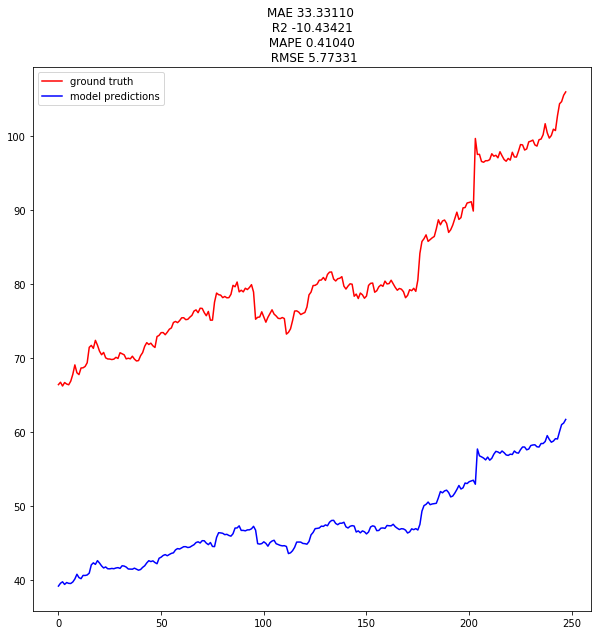

In [102]:
plt.figure(figsize=(10,10))
plt.title("MAE %.5f \n R2 %.5f \n MAPE %.5f \n RMSE %.5f"%(mean_absolute_error(test,pred), r2_score(test,pred), np.mean(np.abs(test-pred)/test), np.sqrt(mean_absolute_error(test,pred))))
plt.plot(test, color='r', label='ground truth')
plt.plot(pred, color='b', label='model predictions')
plt.legend()
plt.show()

In [103]:
fut_train1 = np.zeros_like(fut_train)
pred = model.predict([past_train, fut_train1], batch_size=32)
lin_model = linear_regression(pred, y_train)
pred1 = model.predict([past_test, fut_test])
pred = lin_model.predict(pred1)
pred = np.array(pred).reshape((-1,))
test = y_test.reshape((-1,))

MAE 0.5819
R2 0.9571
RMSE 0.8042


In [104]:
lin_model.coef_

array([1.7534152], dtype=float32)

(248,) (248,)


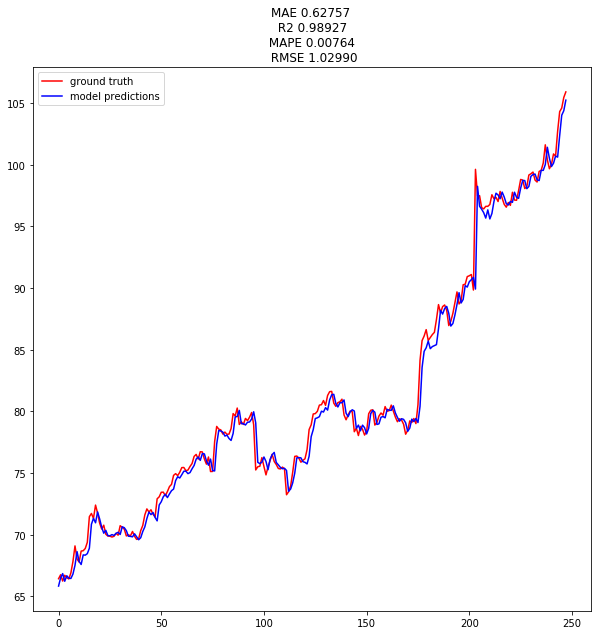

In [105]:
print(pred.shape, test.shape)
plt.figure(figsize=(10,10))
plt.title("MAE %.5f \n R2 %.5f \n MAPE %.5f \n RMSE %.5f"%(mean_absolute_error(test,pred), r2_score(test,pred), np.mean(np.abs(test-pred)/test), np.sqrt(mean_squared_error(test,pred))))
plt.plot(test, color='r', label='ground truth')
plt.plot(pred, color='b', label='model predictions')
plt.legend()
plt.show()

In [22]:
#Pickling the history object.
pkl.dump(history,open("Results/"+str(stocks[0])+'.pkl','wb'))

NameError: name 'history' is not defined

In [32]:
model_pred = model.predict([past_test,past_test], batch_size=32).reshape((-1,1))
linear_pred = pred.reshape((-1,1))
ground_true = test.reshape((-1,1))
results = pd.DataFrame(np.concatenate((ground_true,model_pred,linear_pred),axis=1),columns=['Ground truth', 'Model Predictions','Linear Reg'])
results.to_csv("Results/"+str(stocks[0])+"Dataset combined lstm results.csv",sep=',')

### Original

In [36]:
model = common_lstm_model(past.shape[1:], fut.shape[1:])
from keras.utils import plot_model
plot_model(model, to_file='model.png')
model.fit([past_train, fut_train], y_train, epochs=20, batch_size=32, validation_data=([past_test,fut_test], y_test))

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 10, 4)        0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            (None, 10, 4)        0                                            
__________________________________________________________________________________________________
conv1d_5 (Conv1D)               (None, 6, 256)       5376        input_3[0][0]                    
__________________________________________________________________________________________________
conv1d_7 (Conv1D)               (None, 6, 256)       5376        input_4[0][0]                    
__________________________________________________________________________________________________
conv1d_6 (

Train on 990 samples, validate on 248 samples
Epoch 1/20
990/990 [==============================] - 19s 19ms/step - loss: 319.3224 - mean_absolute_error: 319.8218 - val_loss: 202.1754 - val_mean_absolute_error: 202.6754
Epoch 2/20
990/990 [==============================] - 12s 13ms/step - loss: 176.6343 - mean_absolute_error: 177.1339 - val_loss: 540.5574 - val_mean_absolute_error: 541.0574
Epoch 3/20
990/990 [==============================] - 12s 12ms/step - loss: 113.6896 - mean_absolute_error: 114.1884 - val_loss: 496.9459 - val_mean_absolute_error: 497.4459
Epoch 4/20
990/990 [==============================] - 12s 12ms/step - loss: 36.8789 - mean_absolute_error: 37.3758 - val_loss: 596.8095 - val_mean_absolute_error: 597.3095
Epoch 5/20
990/990 [==============================] - 12s 12ms/step - loss: 31.3734 - mean_absolute_error: 31.8703 - val_loss: 507.3209 - val_mean_absolute_error: 507.8209
Epoch 6/20
990/990 [==============================] - 12s 12ms/step - loss: 81.0417 - me

In [98]:
pred = model.predict([past_test, fut_test], batch_size=32)[-100:]
pred = np.array(pred).reshape((-1,))
test = y_test.reshape((-1,))[-100:]

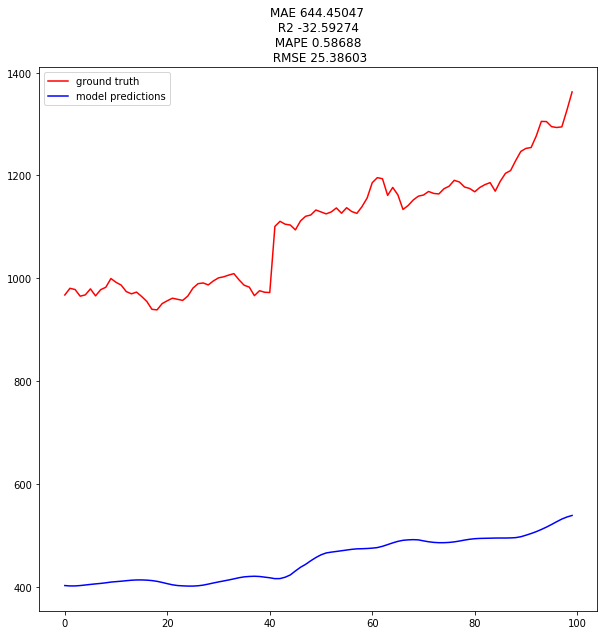

In [38]:
plt.figure(figsize=(10,10))
plt.title("MAE %.5f \n R2 %.5f \n MAPE %.5f \n RMSE %.5f"%(mean_absolute_error(test,pred), r2_score(test,pred), np.mean(np.abs(test-pred)/test), np.sqrt(mean_absolute_error(test,pred))))
plt.plot(test, color='r', label='ground truth')
plt.plot(pred, color='b', label='model predictions')
plt.legend()
plt.show()

In [103]:
fut_train1 = np.zeros_like(fut_train)
pred = model.predict([past_train, fut_train1], batch_size=32)
lin_model = linear_regression(pred, y_train)
pred1 = model.predict([past_test, fut_test])
pred = lin_model.predict(pred1)
pred = np.array(pred).reshape((-1,))
test = y_test.reshape((-1,))

MAE 15.7086
R2 0.9453
RMSE 20.9191


In [40]:
lin_model.coef_

array([2.4861722], dtype=float32)

(248,) (248,)


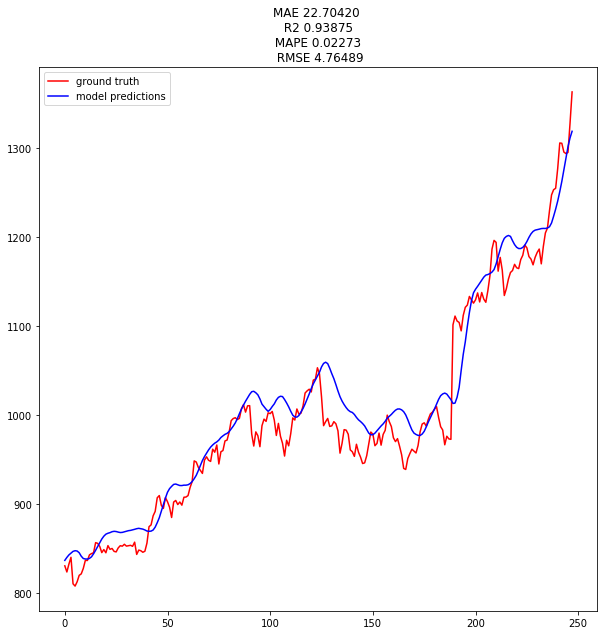

In [41]:
print(pred.shape, test.shape)
plt.figure(figsize=(10,10))
plt.title("MAE %.5f \n R2 %.5f \n MAPE %.5f \n RMSE %.5f"%(mean_absolute_error(test,pred), r2_score(test,pred), np.mean(np.abs(test-pred)/test), np.sqrt(mean_absolute_error(test,pred))))
plt.plot(test, color='r', label='ground truth')
plt.plot(pred, color='b', label='model predictions')
plt.legend()
plt.show()

### Reduced further parameters

In [16]:
model = common_lstm_model(past.shape[1:], fut.shape[1:])
from keras.utils import plot_model
plot_model(model, to_file='model.png')
model.fit([past_train, fut_train], y_train, epochs=150, batch_size=32, validation_data=([past_test,fut_test], y_test))

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 10, 4)        0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            (None, 10, 4)        0                                            
__________________________________________________________________________________________________
conv1d_9 (Conv1D)               (None, 6, 256)       5376        input_5[0][0]                    
__________________________________________________________________________________________________
conv1d_11 (Conv1D)              (None, 6, 256)       5376        input_6[0][0]                    
__________________________________________________________________________________________________
conv1d_10 

Train on 990 samples, validate on 248 samples
Epoch 1/150
990/990 [==============================] - 9s 9ms/step - loss: 167.3976 - mean_absolute_error: 167.8971 - val_loss: 395.4763 - val_mean_absolute_error: 395.9763
Epoch 2/150
990/990 [==============================] - 2s 2ms/step - loss: 107.3971 - mean_absolute_error: 107.8964 - val_loss: 488.3292 - val_mean_absolute_error: 488.8292
Epoch 3/150
990/990 [==============================] - 2s 2ms/step - loss: 48.5686 - mean_absolute_error: 49.0676 - val_loss: 638.6026 - val_mean_absolute_error: 639.1026
Epoch 4/150
990/990 [==============================] - 2s 2ms/step - loss: 40.3718 - mean_absolute_error: 40.8691 - val_loss: 598.9375 - val_mean_absolute_error: 599.4375
Epoch 5/150
990/990 [==============================] - 2s 2ms/step - loss: 67.4418 - mean_absolute_error: 67.9409 - val_loss: 625.9542 - val_mean_absolute_error: 626.4542
Epoch 6/150
990/990 [==============================] - 2s 2ms/step - loss: 44.3781 - mean_absol

Epoch 96/150
990/990 [==============================] - 2s 2ms/step - loss: 15.5144 - mean_absolute_error: 16.0060 - val_loss: 551.8750 - val_mean_absolute_error: 552.3750
Epoch 97/150
990/990 [==============================] - 2s 2ms/step - loss: 9.2683 - mean_absolute_error: 9.7591 - val_loss: 562.9285 - val_mean_absolute_error: 563.4285
Epoch 98/150
990/990 [==============================] - 2s 2ms/step - loss: 11.3208 - mean_absolute_error: 11.8116 - val_loss: 541.2987 - val_mean_absolute_error: 541.7987
Epoch 99/150
990/990 [==============================] - 2s 2ms/step - loss: 14.0611 - mean_absolute_error: 14.5557 - val_loss: 563.8071 - val_mean_absolute_error: 564.3071
Epoch 100/150
990/990 [==============================] - 2s 2ms/step - loss: 9.6803 - mean_absolute_error: 10.1674 - val_loss: 579.0979 - val_mean_absolute_error: 579.5979
Epoch 101/150
990/990 [==============================] - 2s 2ms/step - loss: 12.3397 - mean_absolute_error: 12.8293 - val_loss: 591.6138 - val

In [17]:
pred = model.predict([past_test, fut_test], batch_size=32)[-100:]
pred = np.array(pred).reshape((-1,))
test = y_test.reshape((-1,))[-100:]

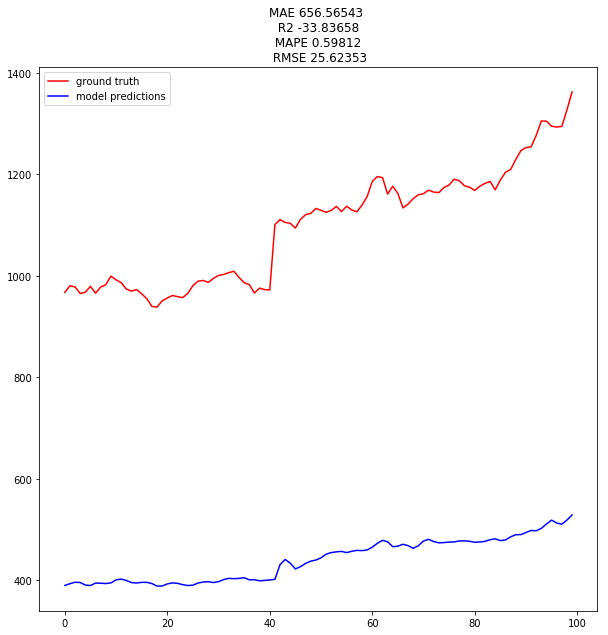

In [18]:
plt.figure(figsize=(10,10))
plt.title("MAE %.5f \n R2 %.5f \n MAPE %.5f \n RMSE %.5f"%(mean_absolute_error(test,pred), r2_score(test,pred), np.mean(np.abs(test-pred)/test), np.sqrt(mean_absolute_error(test,pred))))
plt.plot(test, color='r', label='ground truth')
plt.plot(pred, color='b', label='model predictions')
plt.legend()
plt.show()

In [19]:
fut_train1 = np.zeros_like(fut_train)
pred = model.predict([past_train, fut_train1], batch_size=32)
lin_model = linear_regression(pred, y_train)
pred1 = model.predict([past_test, fut_test])
pred = lin_model.predict(pred1)
pred = np.array(pred).reshape((-1,))
test = y_test.reshape((-1,))

MAE 14.2327
R2 0.9549
RMSE 18.9989


In [20]:
lin_model.coef_

array([2.5332074], dtype=float32)

(248,) (248,)


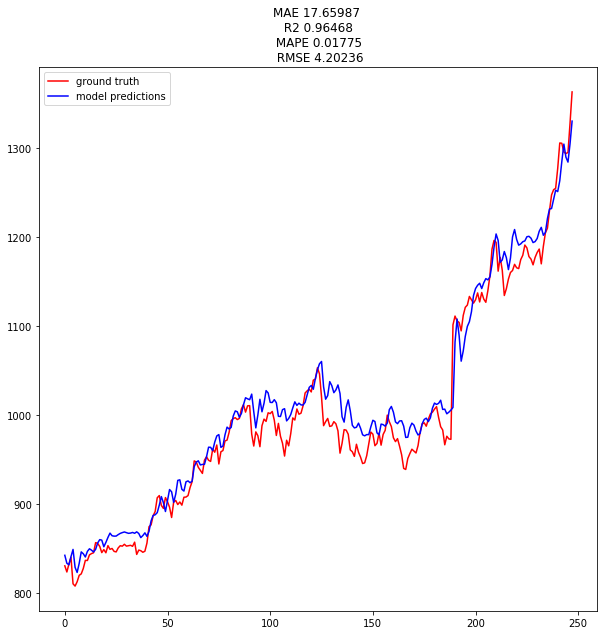

In [21]:
print(pred.shape, test.shape)
plt.figure(figsize=(10,10))
plt.title("MAE %.5f \n R2 %.5f \n MAPE %.5f \n RMSE %.5f"%(mean_absolute_error(test,pred), r2_score(test,pred), np.mean(np.abs(test-pred)/test), np.sqrt(mean_absolute_error(test,pred))))
plt.plot(test, color='r', label='ground truth')
plt.plot(pred, color='b', label='model predictions')
plt.legend()
plt.show()

## Jena Weather Data

In [112]:
data = pd.read_csv("Jena_time_series_data.csv")['T (degC)'].reset_index(drop=True)

In [113]:
time_steps = 21
num_features = 0
past,fut,y = create_formatted_data(data, time_steps, num_features)
past_train, past_test, fut_train, fut_test, y_train, y_test = train_test_split(past,fut,y,data)

In [114]:
model = common_lstm_model(past.shape[1:], fut.shape[1:])
callbacks = [EarlyStopping(monitor='loss',
                              min_delta=0.01,
                              patience=10,
                              verbose=0, mode='auto')]
history_callback = model.fit([past_train, fut_train], y_train, epochs=200, batch_size=32, validation_data=([past_test,fut_test], y_test),callbacks = callbacks)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_15 (InputLayer)           (None, 10, 1)        0                                            
__________________________________________________________________________________________________
input_16 (InputLayer)           (None, 10, 1)        0                                            
__________________________________________________________________________________________________
conv1d_29 (Conv1D)              (None, 6, 64)        384         input_15[0][0]                   
__________________________________________________________________________________________________
conv1d_31 (Conv1D)              (None, 6, 64)        384         input_16[0][0]                   
__________________________________________________________________________________________________
conv1d_30 

In [115]:
pred = model.predict([past_test, fut_test], batch_size=32)
pred = np.array(pred).reshape((-1,))
test = y_test.reshape((-1,))

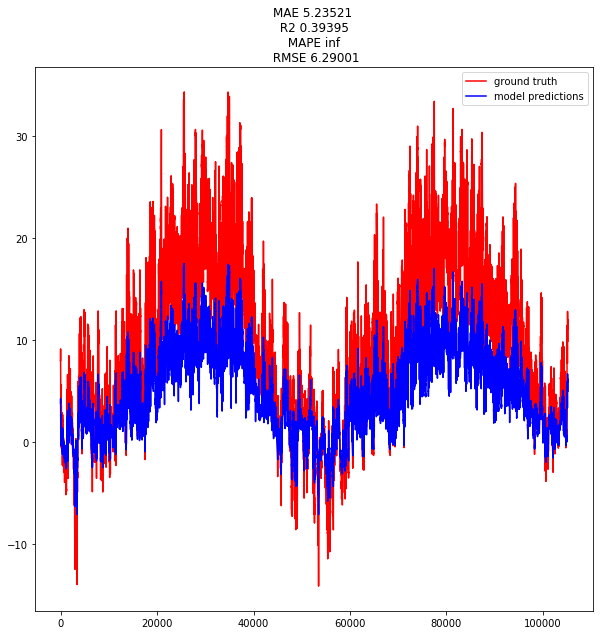

In [116]:
plt.figure(figsize=(10,10))
plt.title("MAE %.5f \n R2 %.5f \n MAPE %.5f \n RMSE %.5f"%(mean_absolute_error(test,pred), r2_score(test,pred), np.mean(np.abs(test-pred)/test), np.sqrt(mean_squared_error(test,pred))))
plt.plot(test, color='r', label='ground truth')
plt.plot(pred, color='b', label='model predictions')
plt.legend()
plt.show()

In [117]:
fut_train1 = np.zeros_like(fut_train)
pred = model.predict([past_train, fut_train1], batch_size=32)
lin_model = linear_regression(pred, y_train)
pred1 = model.predict([past_test, fut_test])
pred = lin_model.predict(pred1)
pred = np.array(pred).reshape((-1,))
test = y_test.reshape((-1,))

MAE 0.3378
R2 0.9963
RMSE 0.4500


In [118]:
lin_model.coef_

array([1.9347842], dtype=float32)

(105159,) (105159,)


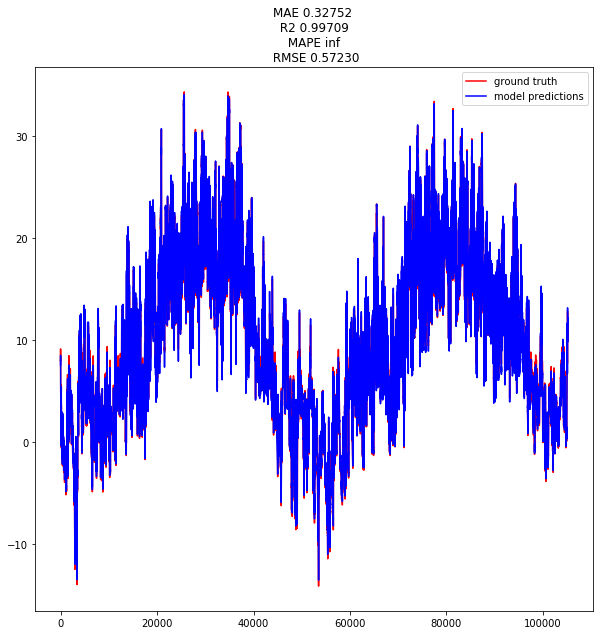

In [119]:
print(pred.shape, test.shape)
plt.figure(figsize=(10,10))
plt.title("MAE %.5f \n R2 %.5f \n MAPE %.5f \n RMSE %.5f"%(mean_absolute_error(test,pred), r2_score(test,pred), np.mean(np.abs(test-pred)/test), np.sqrt(mean_absolute_error(test,pred))))
plt.plot(test, color='r', label='ground truth')
plt.plot(pred, color='b', label='model predictions')
plt.legend()
plt.show()

In [120]:
model_pred = model.predict([past_test,fut_test], batch_size=32).reshape((-1,1))
linear_pred = pred.reshape((-1,1))
ground_true = test.reshape((-1,1))
results = pd.DataFrame(np.concatenate((ground_true,model_pred,linear_pred),axis=1),columns=['Ground truth', 'Model Predictions','Linear Reg'])
results.to_csv("Results/M1_V1_ Jena Dataset.csv",sep=',')

In [121]:
history = {}
for key in (history_callback.history.keys()):
    history[str(key)] = history_callback.history[str(key)]

In [122]:
#Pickling the history object.
pkl.dump(history,open('Results/M1_V1_Jena.pkl','wb'))

## Zurich Sunspot Data 

In [11]:
data = pd.read_csv("monthly-sunspot-number-zurich-17.csv")['Monthly sunspot number, Zurich, 1749-1983']

In [12]:
time_steps = 21
num_features = 0
past,fut,y = create_formatted_data(data, time_steps, num_features)
past_train, past_test, fut_train, fut_test, y_train, y_test = train_test_split(past,fut,y,data)

In [13]:
model = common_lstm_model(past.shape[1:], fut.shape[1:])
model.fit([past_train, fut_train], y_train, epochs=20, batch_size=32, validation_data=([past_test,past_test], y_test))

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 10, 1)        0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            (None, 10, 1)        0                                            
__________________________________________________________________________________________________
conv1d_5 (Conv1D)               (None, 6, 256)       1536        input_3[0][0]                    
__________________________________________________________________________________________________
conv1d_7 (Conv1D)               (None, 6, 256)       1536        input_4[0][0]                    
__________________________________________________________________________________________________
conv1d_6 (

Train on 2239 samples, validate on 560 samples
Epoch 1/20
2239/2239 [==============================] - 34s 15ms/step - loss: 18.9571 - mean_absolute_error: 19.4459 - val_loss: 18.3729 - val_mean_absolute_error: 18.8646
Epoch 2/20
2239/2239 [==============================] - 28s 12ms/step - loss: 12.2866 - mean_absolute_error: 12.7706 - val_loss: 14.9853 - val_mean_absolute_error: 15.4772
Epoch 3/20
2239/2239 [==============================] - 28s 12ms/step - loss: 11.5384 - mean_absolute_error: 12.0208 - val_loss: 24.1609 - val_mean_absolute_error: 24.6555
Epoch 4/20
2239/2239 [==============================] - 28s 12ms/step - loss: 9.9738 - mean_absolute_error: 10.4538 - val_loss: 14.5706 - val_mean_absolute_error: 15.0609
Epoch 5/20
2239/2239 [==============================] - 28s 12ms/step - loss: 9.9077 - mean_absolute_error: 10.3887 - val_loss: 18.7969 - val_mean_absolute_error: 19.2923
Epoch 6/20
2239/2239 [==============================] - 28s 12ms/step - loss: 9.7746 - mean_abs

In [14]:
pred = model.predict([past_test, past_test], batch_size=32)
pred = np.array(pred).reshape((-1,))
test = y_test.reshape((-1,))

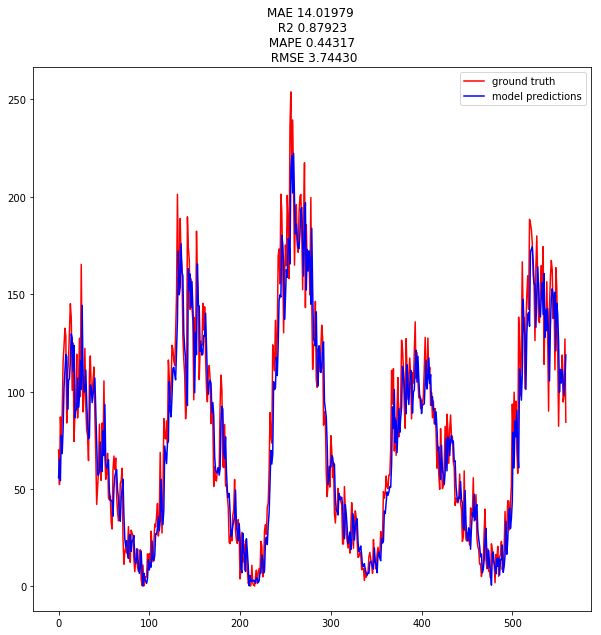

In [15]:
plt.figure(figsize=(10,10))
plt.title("MAE %.5f \n R2 %.5f \n MAPE %.5f \n RMSE %.5f"%(mean_absolute_error(test,pred), r2_score(test,pred), np.mean(np.abs(test-pred)/test), np.sqrt(mean_absolute_error(test,pred))))
plt.plot(test, color='r', label='ground truth')
plt.plot(pred, color='b', label='model predictions')
plt.legend()
plt.show()

In [16]:
fut_train1 = np.zeros_like(fut_train)
pred = model.predict([past_train, fut_train1], batch_size=32)
lin_model = linear_regression(pred, y_train)
pred1 = model.predict([past_test, fut_test])
pred = lin_model.predict(pred1)
pred = np.array(pred).reshape((-1,))
test = y_test.reshape((-1,))

MAE 10.7994
R2 0.7616
RMSE 14.3835


(560,) (560,)


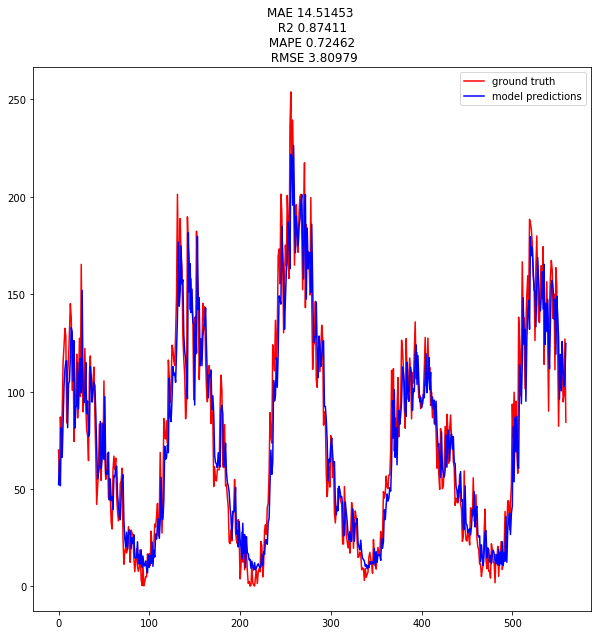

In [17]:
print(pred.shape, test.shape)
plt.figure(figsize=(10,10))
plt.title("MAE %.5f \n R2 %.5f \n MAPE %.5f \n RMSE %.5f"%(mean_absolute_error(test,pred), r2_score(test,pred), np.mean(np.abs(test-pred)/test), np.sqrt(mean_absolute_error(test,pred))))
plt.plot(test, color='r', label='ground truth')
plt.plot(pred, color='b', label='model predictions')
plt.legend()
plt.show()

In [19]:
model_pred = model.predict([past_test,past_test], batch_size=32).reshape((-1,1))
linear_pred = pred.reshape((-1,1))
ground_true = test.reshape((-1,1))
results = pd.DataFrame(np.concatenate((ground_true,model_pred,linear_pred),axis=1),columns=['Ground turth', 'Model Predictions','Linear Reg'])
results.to_csv("Results/Zurich sunspot Dataset combined lstm results.csv",sep=',')

## Google web traffic

In [53]:
data = pd.Series(pd.read_csv("google_web_data/train_2.csv").values[2,1:])

In [61]:
pred, test

(array([4.1955643 , 1.5877421 , 2.912143  , 1.22066   , 2.5278246 ,
        1.7051692 , 2.4514947 , 2.5705566 , 2.1987374 , 2.5353005 ,
        1.3984735 , 2.7569335 , 1.000648  , 4.1474123 , 0.99690706,
        5.16901   , 2.2107522 , 2.993991  , 2.3999922 , 2.2776709 ,
        2.2663374 , 2.68628   , 1.8536617 , 3.6239583 , 0.7778207 ,
        3.8192427 , 0.8796308 , 2.5723011 , 1.183093  , 3.5074477 ,
        1.7188869 , 2.5067742 , 1.4132705 , 2.294779  , 1.7488215 ,
        2.2386317 , 1.2783136 , 1.4552476 , 2.1810174 , 1.7722579 ,
        3.517506  , 1.0114826 , 3.1306708 , 0.86144733, 3.6283476 ,
        2.2819834 , 2.4777052 , 1.4418635 , 2.1463373 , 2.1673002 ,
        2.3145688 , 2.1770096 , 2.2654126 , 1.3230162 , 2.9337573 ,
        2.2382917 , 1.0688256 , 2.3346314 , 1.0766128 , 3.36866   ,
        2.2800384 , 2.1006804 , 2.382124  , 1.9373784 , 5.198689  ,
        1.5236554 , 2.533219  , 2.3521056 , 2.3036635 , 2.2877197 ,
        2.4458568 , 2.0988083 , 2.3633752 , 2.32

In [54]:
time_steps = 21
num_features = 0
past,fut,y = create_formatted_data(data, time_steps, num_features)
past_train, past_test, fut_train, fut_test, y_train, y_test = train_test_split(past,fut,y,data)

In [55]:
model = common_lstm_model(past.shape[1:], fut.shape[1:])
callbacks = [EarlyStopping(monitor='loss',
                              min_delta=0.5,
                              patience=10,
                              verbose=0, mode='auto')]
history_callback = model.fit([past_train, fut_train], y_train, epochs=200, batch_size=32, validation_data=([past_test,fut_test], y_test))

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, 10, 1)        0                                            
__________________________________________________________________________________________________
input_8 (InputLayer)            (None, 10, 1)        0                                            
__________________________________________________________________________________________________
conv1d_13 (Conv1D)              (None, 6, 64)        384         input_7[0][0]                    
__________________________________________________________________________________________________
conv1d_15 (Conv1D)              (None, 6, 64)        384         input_8[0][0]                    
__________________________________________________________________________________________________
conv1d_14 

Epoch 9/200
625/625 [==============================] - 0s 439us/step - loss: 2.5895 - mean_absolute_error: 3.0331 - rmse: 3.0331 - val_loss: 2.0797 - val_mean_absolute_error: 2.5083 - val_rmse: 2.5083
Epoch 10/200
625/625 [==============================] - 0s 436us/step - loss: 2.5135 - mean_absolute_error: 2.9621 - rmse: 2.9621 - val_loss: 2.0995 - val_mean_absolute_error: 2.5247 - val_rmse: 2.5247
Epoch 11/200
625/625 [==============================] - 0s 433us/step - loss: 2.4978 - mean_absolute_error: 2.9424 - rmse: 2.9424 - val_loss: 2.2118 - val_mean_absolute_error: 2.6509 - val_rmse: 2.6509
Epoch 12/200
625/625 [==============================] - 0s 474us/step - loss: 2.4212 - mean_absolute_error: 2.8657 - rmse: 2.8657 - val_loss: 2.0875 - val_mean_absolute_error: 2.5221 - val_rmse: 2.5221
Epoch 13/200
625/625 [==============================] - 0s 441us/step - loss: 2.4004 - mean_absolute_error: 2.8434 - rmse: 2.8434 - val_loss: 2.1079 - val_mean_absolute_error: 2.5416 - val_rmse

Epoch 90/200
625/625 [==============================] - 0s 439us/step - loss: 1.1087 - mean_absolute_error: 1.4628 - rmse: 1.4628 - val_loss: 2.6412 - val_mean_absolute_error: 3.0997 - val_rmse: 3.0997
Epoch 91/200
625/625 [==============================] - 0s 434us/step - loss: 1.0291 - mean_absolute_error: 1.3946 - rmse: 1.3946 - val_loss: 3.0617 - val_mean_absolute_error: 3.5197 - val_rmse: 3.5197
Epoch 92/200
625/625 [==============================] - 0s 442us/step - loss: 1.0795 - mean_absolute_error: 1.4601 - rmse: 1.4601 - val_loss: 2.4956 - val_mean_absolute_error: 2.9421 - val_rmse: 2.9421
Epoch 93/200
625/625 [==============================] - 0s 432us/step - loss: 0.9926 - mean_absolute_error: 1.3471 - rmse: 1.3471 - val_loss: 2.8104 - val_mean_absolute_error: 3.2577 - val_rmse: 3.2577
Epoch 94/200
625/625 [==============================] - 0s 426us/step - loss: 0.9367 - mean_absolute_error: 1.2798 - rmse: 1.2798 - val_loss: 2.9370 - val_mean_absolute_error: 3.3920 - val_rms

625/625 [==============================] - 0s 428us/step - loss: 0.6011 - mean_absolute_error: 0.8619 - rmse: 0.8619 - val_loss: 2.6285 - val_mean_absolute_error: 3.0847 - val_rmse: 3.0847
Epoch 171/200
625/625 [==============================] - 0s 431us/step - loss: 0.6914 - mean_absolute_error: 0.9665 - rmse: 0.9665 - val_loss: 2.8896 - val_mean_absolute_error: 3.3436 - val_rmse: 3.3436
Epoch 172/200
625/625 [==============================] - 0s 459us/step - loss: 0.6911 - mean_absolute_error: 0.9726 - rmse: 0.9726 - val_loss: 2.6650 - val_mean_absolute_error: 3.1226 - val_rmse: 3.1226
Epoch 173/200
625/625 [==============================] - 0s 450us/step - loss: 0.5801 - mean_absolute_error: 0.8539 - rmse: 0.8539 - val_loss: 2.4986 - val_mean_absolute_error: 2.9433 - val_rmse: 2.9433
Epoch 174/200
625/625 [==============================] - 0s 429us/step - loss: 0.5857 - mean_absolute_error: 0.8529 - rmse: 0.8529 - val_loss: 2.7599 - val_mean_absolute_error: 3.2271 - val_rmse: 3.2271

In [56]:
pred = model.predict([past_test, fut_test], batch_size=32)
pred = np.array(pred).reshape((-1,))
test = y_test.reshape((-1,))

In [57]:
plt.figure(figsize=(10,10))
plt.title("MAE %.5f \n R2 %.5f \n MAPE %.5f \n RMSE %.5f"%(mean_absolute_error(test,pred), r2_score(test,pred), np.mean(np.abs(test-pred)/test), np.sqrt(mean_squared_error(test,pred))))
plt.plot(test, color='r', label='ground truth')
plt.plot(pred, color='b', label='model predictions')
plt.legend()
plt.show()

ZeroDivisionError: float division by zero

<Figure size 720x720 with 0 Axes>

In [ ]:
fut_train1 = np.zeros_like(fut_train)
pred = model.predict([past_train, fut_train1], batch_size=32)
lin_model = linear_regression(pred, y_train)
pred1 = model.predict([past_test, fut_test])
pred = lin_model.predict(pred1)
pred = np.array(pred).reshape((-1,))
test = y_test.reshape((-1,))

In [ ]:
lin_model.coef_

In [ ]:
print(pred.shape, test.shape)
plt.figure(figsize=(10,10))
plt.title("MAE %.5f \n R2 %.5f \n MAPE %.5f \n RMSE %.5f"%(mean_absolute_error(test,pred), r2_score(test,pred), np.mean(np.abs(test-pred)/test), np.sqrt(mean_absolute_error(test,pred))))
plt.plot(test, color='r', label='ground truth')
plt.plot(pred, color='b', label='model predictions')
plt.legend()
plt.show()

In [ ]:
print(2*np.sum(np.abs(pred-test)/(pred+test))/pred.shape[0])

## Brain seizures

In [50]:
data = pd.read_csv("../Time Series datasets/eeg/data.csv").iloc[:,1:]
for i in range(data.shape[0]):
    if(data['y'][i] != 1): 
        data['y'][i] = 0

In [51]:
time_steps = 21
num_features = 178
past,fut,y = create_formatted_data(data, time_steps, num_features)
past_train, past_test, fut_train, fut_test, y_train, y_test = train_test_split(past,fut,y,data)

In [52]:
model = common_lstm_model(past.shape[1:], fut.shape[1:])
callbacks = [EarlyStopping(monitor='loss',
                              min_delta=0.,
                              patience=10,
                              verbose=0, mode='auto')]
history_callback = model.fit([past_train, fut_train], y_train, epochs=30, batch_size=32, validation_data=([past_test,fut_test], y_test))

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_15 (InputLayer)           (None, 10, 179)      0                                            
__________________________________________________________________________________________________
input_16 (InputLayer)           (None, 10, 179)      0                                            
__________________________________________________________________________________________________
conv1d_29 (Conv1D)              (None, 6, 16)        14336       input_15[0][0]                   
__________________________________________________________________________________________________
conv1d_31 (Conv1D)              (None, 6, 16)        14336       input_16[0][0]                   
__________________________________________________________________________________________________
conv1d_30 

Epoch 12/30
9183/9183 [==============================] - 3s 349us/step - loss: 3.2173 - mean_absolute_error: 0.3198 - acc: 0.8004 - val_loss: 3.2433 - val_mean_absolute_error: 0.3207 - val_acc: 0.7988
Epoch 13/30
9183/9183 [==============================] - 3s 342us/step - loss: 3.2173 - mean_absolute_error: 0.3198 - acc: 0.8004 - val_loss: 3.2433 - val_mean_absolute_error: 0.3207 - val_acc: 0.7988
Epoch 14/30
9183/9183 [==============================] - 3s 345us/step - loss: 3.2173 - mean_absolute_error: 0.3198 - acc: 0.8004 - val_loss: 3.2433 - val_mean_absolute_error: 0.3207 - val_acc: 0.7988
Epoch 15/30
9183/9183 [==============================] - 3s 351us/step - loss: 3.2173 - mean_absolute_error: 0.3198 - acc: 0.8004 - val_loss: 3.2433 - val_mean_absolute_error: 0.3207 - val_acc: 0.7988
Epoch 16/30
9183/9183 [==============================] - 3s 345us/step - loss: 3.2173 - mean_absolute_error: 0.3198 - acc: 0.8004 - val_loss: 3.2433 - val_mean_absolute_error: 0.3207 - val_acc: 0.

In [56]:
plt.figure(figsize=(10,10))
plt.title("MAE %.5f \n R2 %.5f \n MAPE %.5f \n RMSE %.5f"%(mean_absolute_error(test,pred), r2_score(test,pred), np.mean(np.abs(test-pred)/test), np.sqrt(mean_squared_error(test,pred))))
plt.plot(test, color='r', label='ground truth')
plt.plot(pred, color='b', label='model predictions')
plt.legend()
plt.show()

ValueError: Found input variables with inconsistent numbers of samples: [2296, 11480]

<Figure size 720x720 with 0 Axes>

In [117]:
fut_train1 = np.zeros_like(fut_train)
pred = model.predict([past_train, fut_train1], batch_size=32)
lin_model = linear_regression(pred, y_train)
pred1 = model.predict([past_test, fut_test])
pred = lin_model.predict(pred1)
pred = np.array(pred).reshape((-1,))
test = y_test.reshape((-1,))

MAE 0.3378
R2 0.9963
RMSE 0.4500


In [118]:
lin_model.coef_

array([1.9347842], dtype=float32)

(105159,) (105159,)


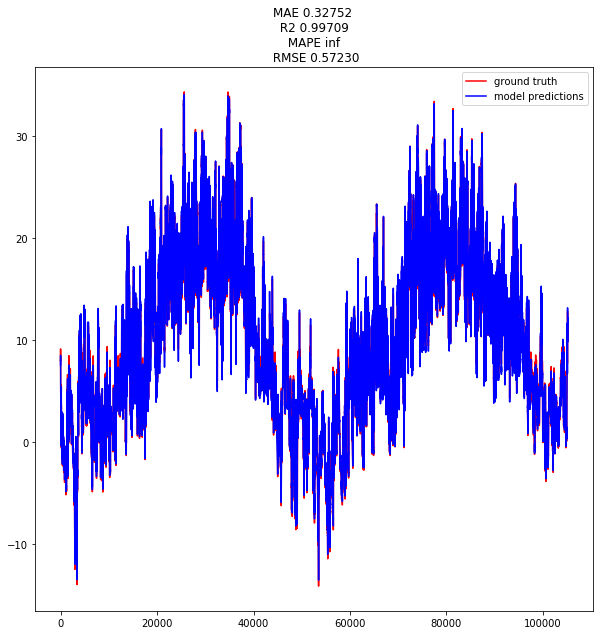

In [119]:
print(pred.shape, test.shape)
plt.figure(figsize=(10,10))
plt.title("MAE %.5f \n R2 %.5f \n MAPE %.5f \n RMSE %.5f"%(mean_absolute_error(test,pred), r2_score(test,pred), np.mean(np.abs(test-pred)/test), np.sqrt(mean_absolute_error(test,pred))))
plt.plot(test, color='r', label='ground truth')
plt.plot(pred, color='b', label='model predictions')
plt.legend()
plt.show()

In [120]:
model_pred = model.predict([past_test,fut_test], batch_size=32).reshape((-1,1))
linear_pred = pred.reshape((-1,1))
ground_true = test.reshape((-1,1))
results = pd.DataFrame(np.concatenate((ground_true,model_pred,linear_pred),axis=1),columns=['Ground truth', 'Model Predictions','Linear Reg'])
results.to_csv("Results/M1_V1_ Jena Dataset.csv",sep=',')

In [121]:
history = {}
for key in (history_callback.history.keys()):
    history[str(key)] = history_callback.history[str(key)]

In [122]:
#Pickling the history object.
pkl.dump(history,open('Results/M1_V1_Jena.pkl','wb'))

## Solar Energy prediction

## Earthquake data

In [20]:
data = pd.read_csv("../Time Series datasets/all_month.csv").iloc[:,1:5]
data = data.replace(to_replace=np.nan, value=1.5)

In [21]:
time_steps = 21
num_features = 3
past,fut,y = create_formatted_data(data, time_steps, num_features)
past_train, past_test, fut_train, fut_test, y_train, y_test = train_test_split(past,fut,y,data)

In [ ]:
model = common_lstm_model(past.shape[1:], fut.shape[1:])
callbacks = [EarlyStopping(monitor='loss',
                              min_delta=0.01,
                              patience=10,
                              verbose=0, mode='auto')]
history_callback = model.fit([past_train, fut_train], y_train, epochs=20, batch_size=32, validation_data=([past_test,fut_test], y_test))

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 10, 4)        0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            (None, 10, 4)        0                                            
__________________________________________________________________________________________________
conv1d_5 (Conv1D)               (None, 6, 16)        336         input_3[0][0]                    
__________________________________________________________________________________________________
conv1d_7 (Conv1D)               (None, 6, 16)        336         input_4[0][0]                    
__________________________________________________________________________________________________
conv1d_6 (

In [ ]:
pred = model.predict([past_test, fut_test], batch_size=32)
pred = np.array(pred).reshape((-1,))
test = y_test.reshape((-1,))

In [ ]:
plt.figure(figsize=(10,10))
plt.title("MAE %.5f \n R2 %.5f \n MAPE %.5f \n RMSE %.5f"%(mean_absolute_error(test,pred), r2_score(test,pred), np.mean(np.abs(test-pred)/test), np.sqrt(mean_squared_error(test,pred))))
plt.plot(test, color='r', label='ground truth')
plt.plot(pred, color='b', label='model predictions')
plt.legend()
plt.show()

In [117]:
fut_train1 = np.zeros_like(fut_train)
pred = model.predict([past_train, fut_train1], batch_size=32)
lin_model = linear_regression(pred, y_train)
pred1 = model.predict([past_test, fut_test])
pred = lin_model.predict(pred1)
pred = np.array(pred).reshape((-1,))
test = y_test.reshape((-1,))

MAE 0.3378
R2 0.9963
RMSE 0.4500


In [118]:
lin_model.coef_

array([1.9347842], dtype=float32)

(105159,) (105159,)


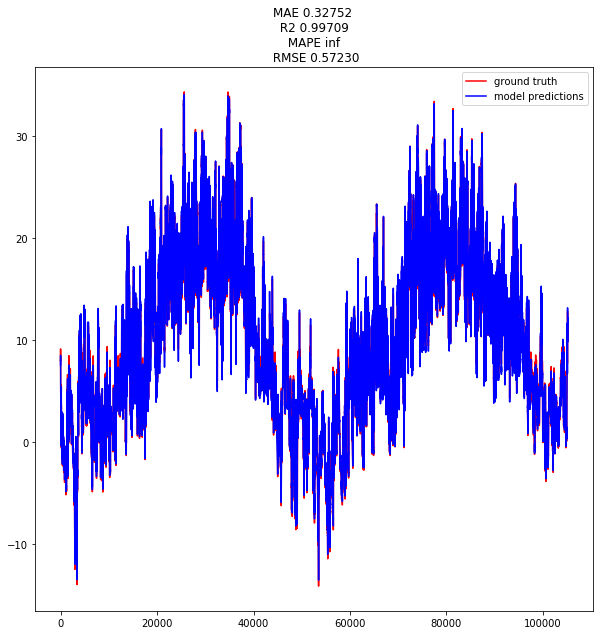

In [119]:
print(pred.shape, test.shape)
plt.figure(figsize=(10,10))
plt.title("MAE %.5f \n R2 %.5f \n MAPE %.5f \n RMSE %.5f"%(mean_absolute_error(test,pred), r2_score(test,pred), np.mean(np.abs(test-pred)/test), np.sqrt(mean_absolute_error(test,pred))))
plt.plot(test, color='r', label='ground truth')
plt.plot(pred, color='b', label='model predictions')
plt.legend()
plt.show()

In [120]:
model_pred = model.predict([past_test,fut_test], batch_size=32).reshape((-1,1))
linear_pred = pred.reshape((-1,1))
ground_true = test.reshape((-1,1))
results = pd.DataFrame(np.concatenate((ground_true,model_pred,linear_pred),axis=1),columns=['Ground truth', 'Model Predictions','Linear Reg'])
results.to_csv("Results/M1_V1_ Jena Dataset.csv",sep=',')

In [121]:
history = {}
for key in (history_callback.history.keys()):
    history[str(key)] = history_callback.history[str(key)]

In [122]:
#Pickling the history object.
pkl.dump(history,open('Results/M1_V1_Jena.pkl','wb'))

# CNN weights

In [178]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, 10, 1)        0                                            
__________________________________________________________________________________________________
input_8 (InputLayer)            (None, 10, 1)        0                                            
__________________________________________________________________________________________________
conv1d_13 (Conv1D)              (None, 6, 16)        96          input_7[0][0]                    
__________________________________________________________________________________________________
conv1d_15 (Conv1D)              (None, 6, 16)        96          input_8[0][0]                    
__________________________________________________________________________________________________
conv1d_14 

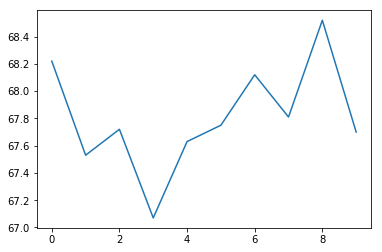

In [187]:
plt.figure()
for i in range(14,15):
    plt.plot(past_train[i])
plt.show()

In [188]:
i_data = past_train[14]
o_data = fut_train[14]
#i_data = i_data[np.newaxis,:,:]

In [189]:
layer_count = 0
kernels_chosen = 16
kernels = {}
for layer in model.layers:
    if ( (layer_count == 2) or (layer_count == 4) ):
        kernels[layer_count] = (layer.get_weights()[0][:,:,-kernels_chosen:])
    layer_count += 1

In [190]:
ress1 = []
ress2 = []
for j in range(kernels_chosen):
    res1 = []
    for i in range(i_data.shape[0]-kernels[2].shape[0]+1):
        res1.append(np.sum(np.dot(kernels[2][:,:,j],np.transpose(i_data[i:(i+5),:]))))
    ress1.append(res1)
ress1 = np.array(ress1)

In [191]:
ress1 = np.transpose(ress1, (1,0))
ress1.shape

(6, 16)

In [192]:
for j in range(kernels_chosen-8):
    res1 = []
    for i in range(ress1.shape[0]-kernels[4].shape[0]+1):
        res1.append(np.sum(np.dot(kernels[4][:,:,j],np.transpose(ress1[i:(i+3),:]))))
    ress2.append(res1)

In [195]:
ress1 = np.transpose(ress1, (1,0))

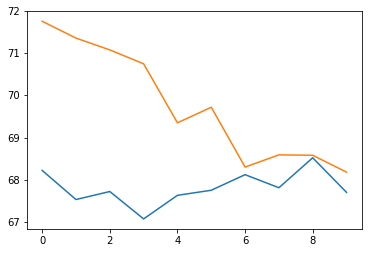

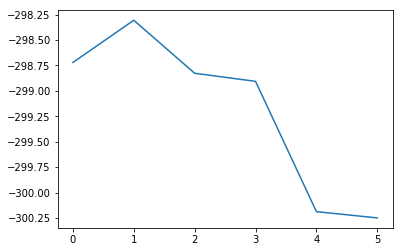

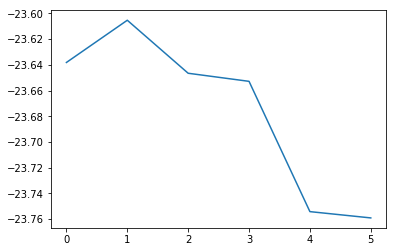

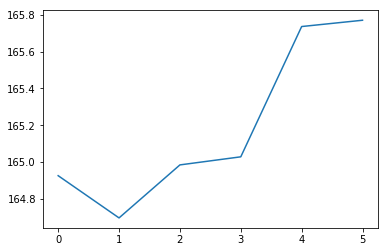

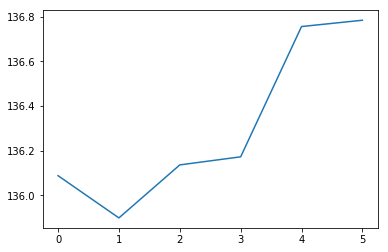

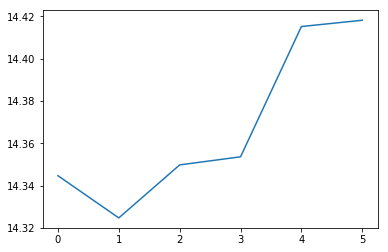

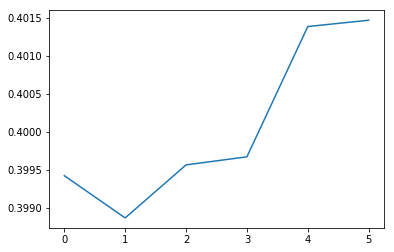

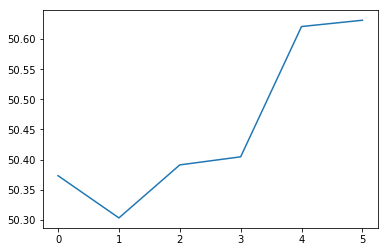

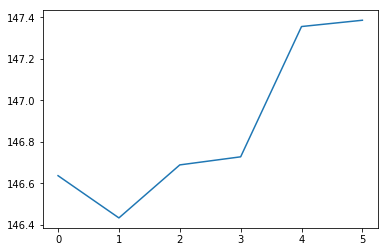

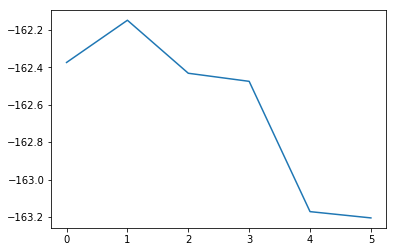

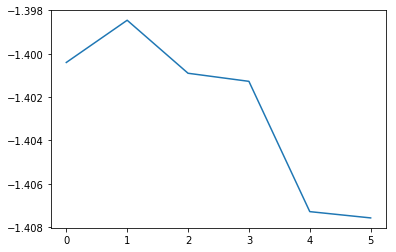

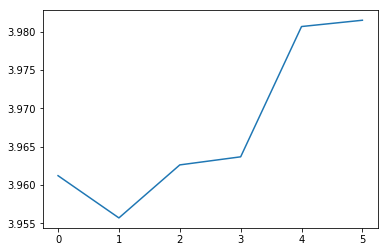

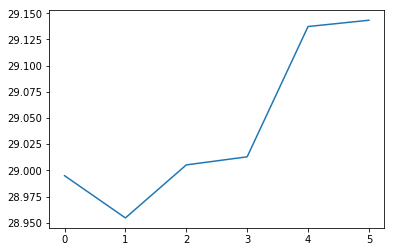

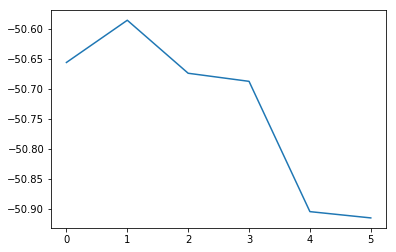

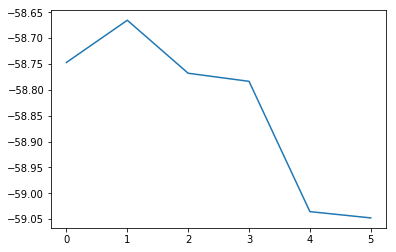

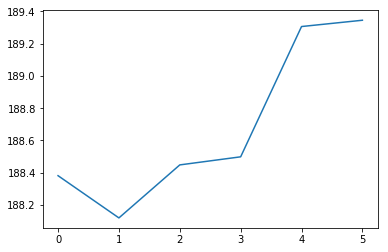

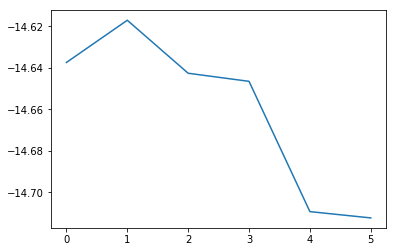

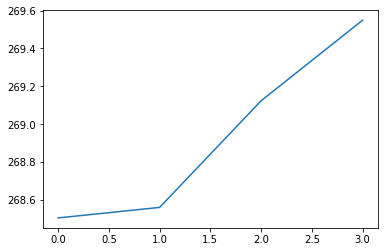

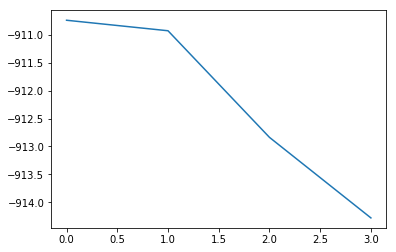

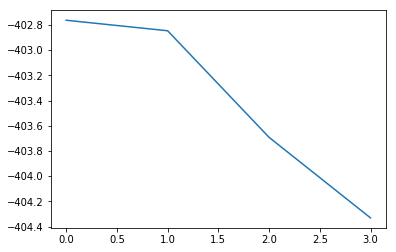

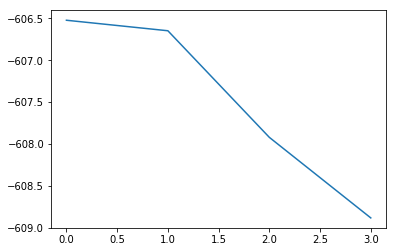

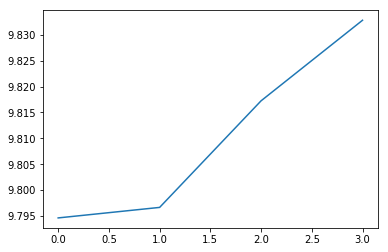

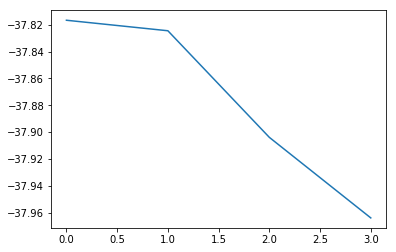

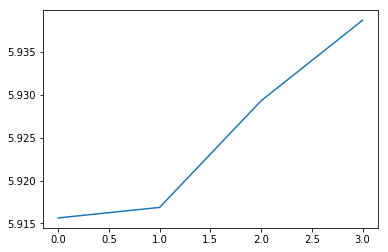

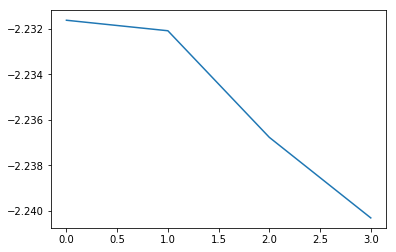

In [199]:
plt.plot(i_data)
plt.plot(o_data)
plt.show()
for k in range(len(ress1)):
    plt.plot(ress1[k])
    plt.show()
for k in range(len(ress2)):
    plt.plot(ress2[k])
    plt.show()